# Setup and Imports

In [1]:
!pip3 install -r ../requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '../requirements.txt'

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.ticker as ticker

# Universal (Function) Utilities

### Graph based

In [30]:
def load_all_days_prices(round_, days, root_path, filename_pattern='prices_round_{round_}_day_{day}.csv', sep=';'):
    """
    Loads and concatenates price files for all specified days,
    adding a 'day' column.
    """
    dfs = []
    
    for day in days:
        path = os.path.join(root_path, filename_pattern.format(round_=round_, day=day))
        df = pd.read_csv(path, sep=sep)
        df['day'] = day
        dfs.append(df)
    
    return pd.concat(dfs, ignore_index=True)

def plot_prices_across_days(df, product, days, figsize=(16,8)):
    """
    Plots mid_price (solid) and profit_and_loss (dashed) for a single product
    across multiple days, exactly as in your original function.
    """
    fig, ax1 = plt.subplots(figsize=figsize)
    colors = ['blue', 'green', 'red'][:len(days)]
    ax2 = None

    for day, color in zip(days, colors):
        df_day = df[(df['product'] == product) & (df['day'] == day)]
    
        if df_day.empty:
            continue

        # mid price
        ax1.plot(df_day['timestamp'], df_day['mid_price'],
                 label=f'Day {day} – Mid Price',
                 color=color, linestyle='-')
        # pnl
        if ax2 is None:
            ax2 = ax1.twinx()
        ax2.plot(df_day['timestamp'], df_day['profit_and_loss'],
                 label=f'Day {day} – PnL',
                 color=color, linestyle='--')

    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Mid Price')
    ax1.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")
    
    if ax2:
        ax2.set_ylabel('PnL')

        # Combining legends
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2,
                   loc='upper left', bbox_to_anchor=(1.0, 1.0))

    plt.title(f'Mid Price & PnL Over Time – {product}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def load_all_days_trades(round_, days, root_path, filename_pattern='trades_round_{round_}_day_{day}.csv', sep=';'):
    dfs = []

    for day in days:
        path = os.path.join(root_path, filename_pattern.format(round_=round_, day=day))
        df = pd.read_csv(path, sep=';')
        df['day'] = day
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

def plot_trades_across_days(df, product, days, figsize=(16,8)):
    fig, ax1 = plt.subplots(figsize=figsize)

    colors = ['purple', 'darkorange', 'teal']

    for day, color in zip(days, colors):
        df_day = df[(df['symbol'] == product) & (df['day'] == day)]
     
        if df_day.empty:
            continue

        label_price = f'Day {day} - Trade Price'
        label_qty = f'Day {day} - Quantity'

        ax1.plot(df_day['timestamp'], df_day['price'], label=label_price, color=color, linestyle='-')
        ax1.set_ylabel('Trade Price')

        # ax2 = ax1.twinx()
        # ax2.plot(df_day['timestamp'], df_day['quantity'], label=label_qty, color=color, linestyle='--')
        # ax2.set_ylabel('Quantity')

    # X-axis formatting
    ax1.set_xlabel('Timestamp')
    ax1.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    # lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1, labels1, loc='upper left', bbox_to_anchor=(1.0, 1.0))

    plt.title(f'Trade Price and Quantity Over Time Across Days - {product}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_observation_variable_across_days(df, variable, days):
    fig, ax = plt.subplots(figsize=(16, 8))
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'teal']

    for day, color in zip(days, colors):
        df_day = df[df['day'] == day]
        
        if df_day.empty:
            continue

        ax.plot(df_day['timestamp'], df_day[variable], label=f'Day {day} - {variable}', color=color)

    ax.set_xlabel('Timestamp')
    ax.set_ylabel(variable)
    ax.set_title(f'{variable} Over Time Across Days')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    ax.grid(True)
    plt.tight_layout()
    plt.show()

### Stat based

In [35]:
# Loading & Preprocessing
def load_all_days_prices(round_, days, root_path, filename_pattern='prices_round_{round_}_day_{day}.csv', sep=';'):
    """See graph_utils.load_all_days_prices; duplicated here for stats module."""
    dfs = []

    for day in days:
        path = os.path.join(root_path, filename_pattern.format(round_=round_, day=day))
        df = pd.read_csv(path, sep=sep)
        df['day'] = day
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

def load_all_days_trades(round_, days, root_path, filename_pattern='trades_round_{round_}_day_{day}.csv', sep=';'):
    """Loads and concatenates trade files for all specified days, adding a 'day' column."""
    dfs = []

    for day in days:
        path = os.path.join(root_path, filename_pattern.format(round_=round_, day=day))
        df = pd.read_csv(path, sep=sep)
        df['day'] = day
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

def preprocess_prices(prices: pd.DataFrame) -> pd.DataFrame:
    """Convert timestamp to datetime, compute spread and log‐returns."""
    prices = prices.copy()
    prices['timestamp'] = pd.to_datetime(prices['timestamp'], unit='s')
    
    # best‐level spread
    prices['spread'] = prices['ask_price_1'] - prices['bid_price_1']
    
    # log return on mid_price
    prices['log_mid'] = np.log(prices['mid_price'])
    prices['return'] = prices.groupby(['product','day'])['log_mid'].diff().fillna(0)
    
    return prices

def preprocess_trades(trades: pd.DataFrame) -> pd.DataFrame:
    """Convert timestamp to datetime and compute inter‐arrival times & trade‐size stats."""
    trades = trades.copy()
    trades['timestamp'] = pd.to_datetime(trades['timestamp'], unit='s')
    trades = trades.sort_values(['symbol','day','timestamp'])
    
    # inter-arrival (in seconds) per symbol/day
    trades['prev_ts'] = trades.groupby(['symbol','day'])['timestamp'].shift(1)
    trades['inter_arrival'] = (
        trades['timestamp'] - trades['prev_ts']
    ).dt.total_seconds().fillna(0)
    
    return trades

# Price Data Analysis
def analyze_prices(prices: pd.DataFrame) -> pd.DataFrame:
    """
    For each product/day compute:
      • mean, std, min, max, median, skew, kurtosis of mid_price
      • mean & std of spread
      • realized volatility = sqrt(sum(return^2))
      • entry count
    """
    stats = []
    grp = prices.groupby(['product','day'])
    
    for (product, day), df in grp:
        mid = df['mid_price']
        spreads = df['spread']
        rets   = df['return']
        realized_vol = np.sqrt((rets**2).sum())
        stats.append({
            'product': product,
            'day': day,
            'mean_mid': mid.mean(),
            'std_mid': mid.std(),
            'min_mid': mid.min(),
            'max_mid': mid.max(),
            'median_mid': mid.median(),
            'skew_mid': mid.skew(),
            'kurtosis_mid': mid.kurtosis(),
            'mean_spread': spreads.mean(),
            'std_spread': spreads.std(),
            'realized_volatility': realized_vol,
            'price_entry_count': len(df)
        })

    return pd.DataFrame(stats)

# Trade Data Analysis
def analyze_trades(trades: pd.DataFrame) -> pd.DataFrame:
    """
    For each symbol/day compute:
      • trade count
      • total volume, mean/median trade size, size std, max size
      • mean, std, min, max, median price
      • VWAP
      • price volatility (std)
      • mean & std of inter-arrival times
    """
    stats = []
    grp = trades.groupby(['symbol','day'])
    
    for (sym, day), df in grp:
        qty = df['quantity']
        prc = df['price']
        total_vol = qty.sum()
        vwap = (prc * qty).sum() / total_vol if total_vol else np.nan
        stats.append({
            'product': sym,
            'day': day,
            'trade_count': len(df),
            'total_volume': total_vol,
            'mean_trade_price': prc.mean(),
            'median_trade_price': prc.median(),
            'std_trade_price': prc.std(),
            'min_trade_price': prc.min(),
            'max_trade_price': prc.max(),
            'vwap': vwap,
            'mean_trade_size': qty.mean(),
            'median_trade_size': qty.median(),
            'std_trade_size': qty.std(),
            'max_trade_size': qty.max(),
            'mean_inter_arrival_s': df['inter_arrival'].mean(),
            'std_inter_arrival_s': df['inter_arrival'].std()
        })

    return pd.DataFrame(stats)

# Export Helpers
def export_stats(df: pd.DataFrame, out_csv_path: str):
    """Exports any stats DataFrame to CSV (with index=False)."""
    df.to_csv(out_csv_path, index=False)

def load_all_days_observations(round_, days, root_path):
    dfs = []
    
    for day in days:
        path = os.path.join(root_path, f'observations_round_{round_}_day_{day}.csv')
        df = pd.read_csv(path, sep=',')
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        df['day'] = day
        dfs.append(df)
    
    return pd.concat(dfs, ignore_index=True)

def analyze_observations(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyzes the observation data per day:
    - Computes summary statistics for each observation variable.
    """
    observation_cols = ['bidPrice', 'askPrice', 'transportFees', 'exportTariff', 'importTariff', 'sugarPrice', 'sunlightIndex']
    stats = df.groupby('day')[observation_cols].agg(['mean', 'std', 'min', 'max', 'median', 'count'])
    stats.columns = ['_'.join(col) for col in stats.columns]
    stats.reset_index(inplace=True)

    return stats

# Round 3

### EDA

In [5]:
prices_df = pd.read_csv('../../data/round-3-island-data-bottle/prices_round_3_day_0.csv', sep=';')
trades_df = pd.read_csv('../../data/round-3-island-data-bottle/trades_round_3_day_0.csv', sep=';')

In [6]:
prices_df.head() 

day  timestamp                      product  bid_price_1  bid_volume_1  \
0    0          0  VOLCANIC_ROCK_VOUCHER_10500         99.0          19.0   
1    0          0                      DJEMBES      13493.0          72.0   
2    0          0                   CROISSANTS       4321.0         111.0   
3    0          0                         JAMS       6631.0         210.0   
4    0          0  VOLCANIC_ROCK_VOUCHER_10000        505.0          19.0   

   bid_price_2  bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  \
0          NaN           NaN          NaN           NaN          100   
1          NaN           NaN          NaN           NaN        13494   
2          NaN           NaN          NaN           NaN         4322   
3          NaN           NaN          NaN           NaN         6633   
4          NaN           NaN          NaN           NaN          506   

   ask_volume_1  ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  \
0            19          NaN           NaN          NaN           NaN   
1            72          NaN           NaN          NaN           NaN   
2           111          NaN           NaN          NaN           NaN   
3           210          NaN           NaN          NaN           NaN   
4            19          NaN           NaN          NaN           NaN   

   mid_price  profit_and_loss  
0       99.5              0.0  
1    13493.5              0.0  
2     4321.5              0.0  
3     6632.0              0.0  
4      505.5              0.0

In [7]:
trades_df.head()

timestamp  buyer  seller            symbol   currency    price  quantity
0          0    NaN     NaN        CROISSANTS  SEASHELLS   4322.0         8
1          0    NaN     NaN           DJEMBES  SEASHELLS  13494.0         3
2          0    NaN     NaN  RAINFOREST_RESIN  SEASHELLS   9992.0         8
3        200    NaN     NaN  RAINFOREST_RESIN  SEASHELLS  10008.0         2
4        300    NaN     NaN              KELP  SEASHELLS   2029.0         6

### Generating insights

In [13]:
round_ = 3

# Specifying your days and root folder:
days = [0, 1, 2]
root = f'../../data/round-{round_}-island-data-bottle/'

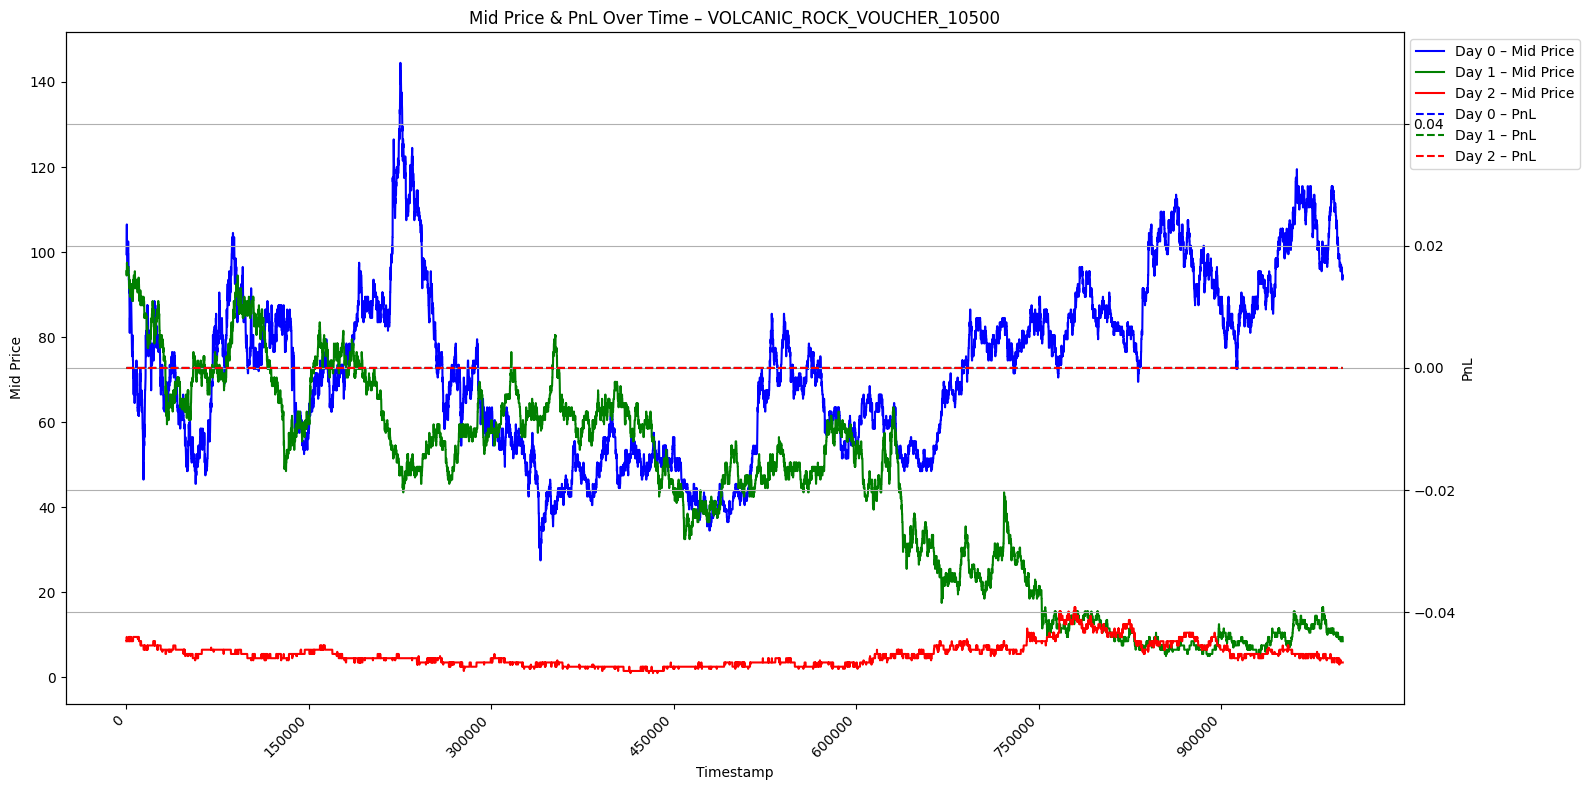

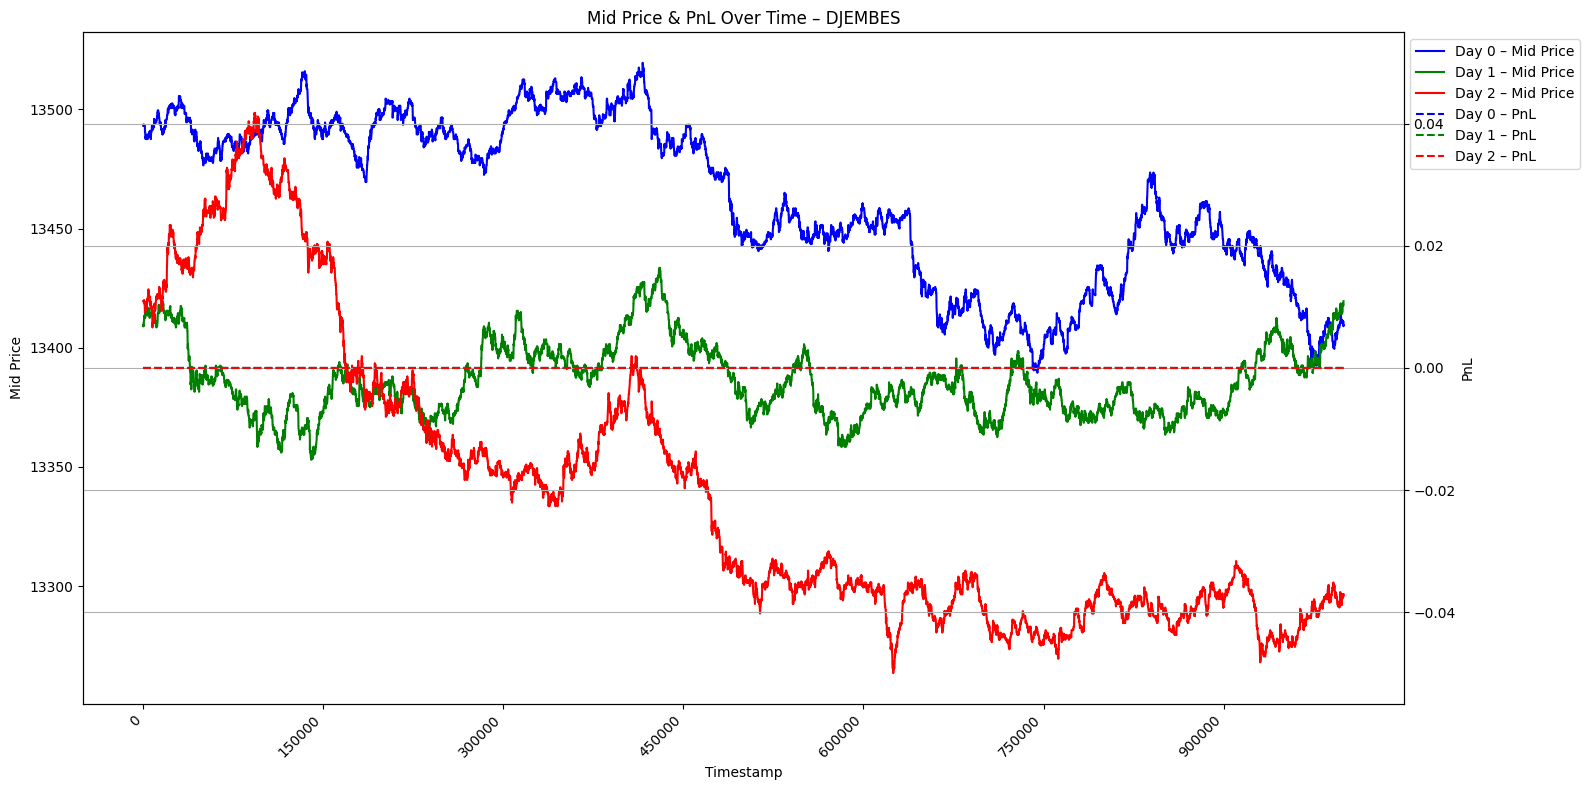

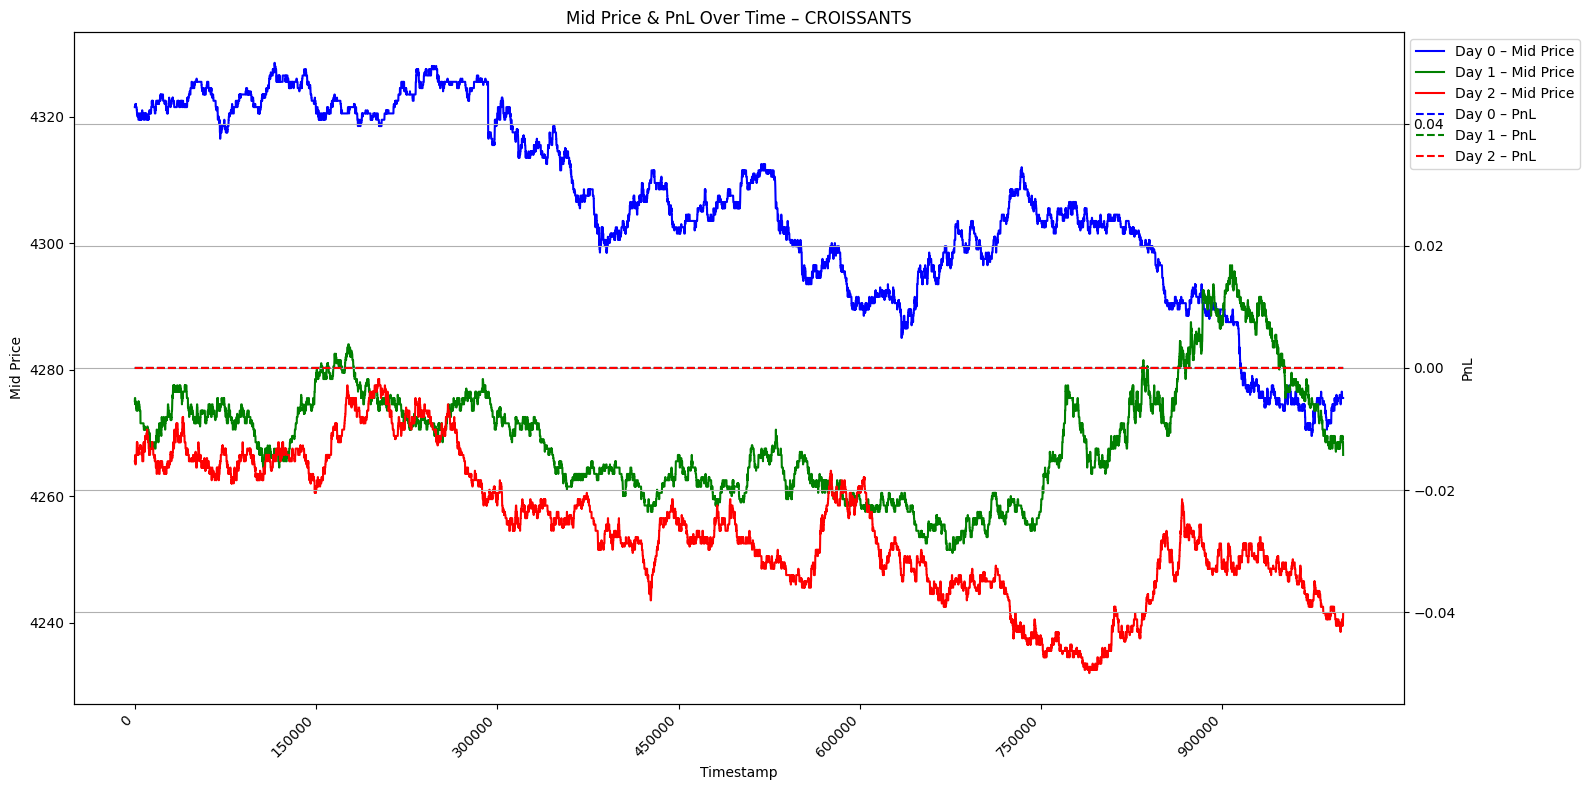

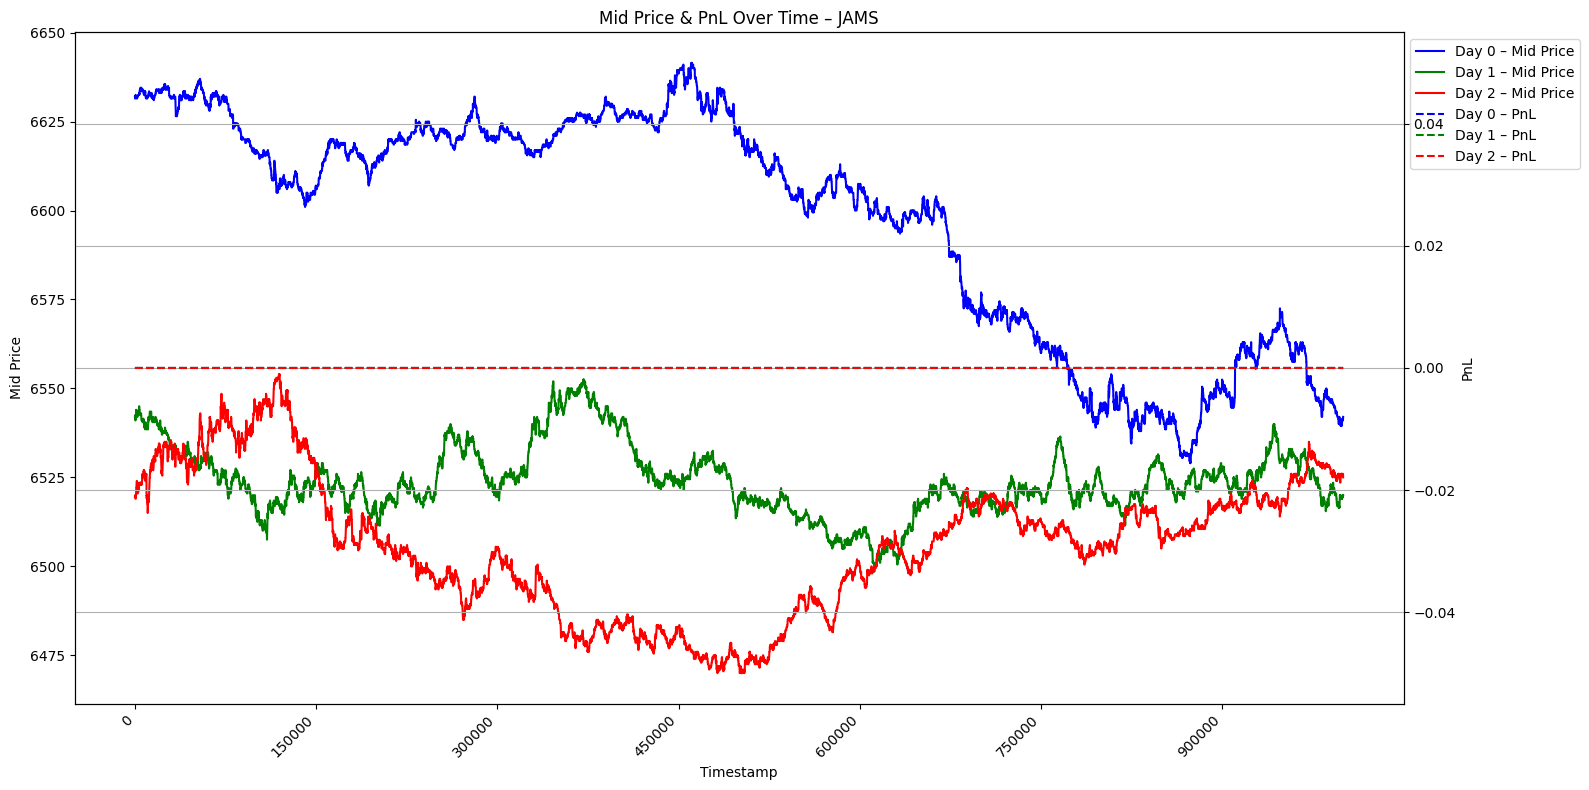

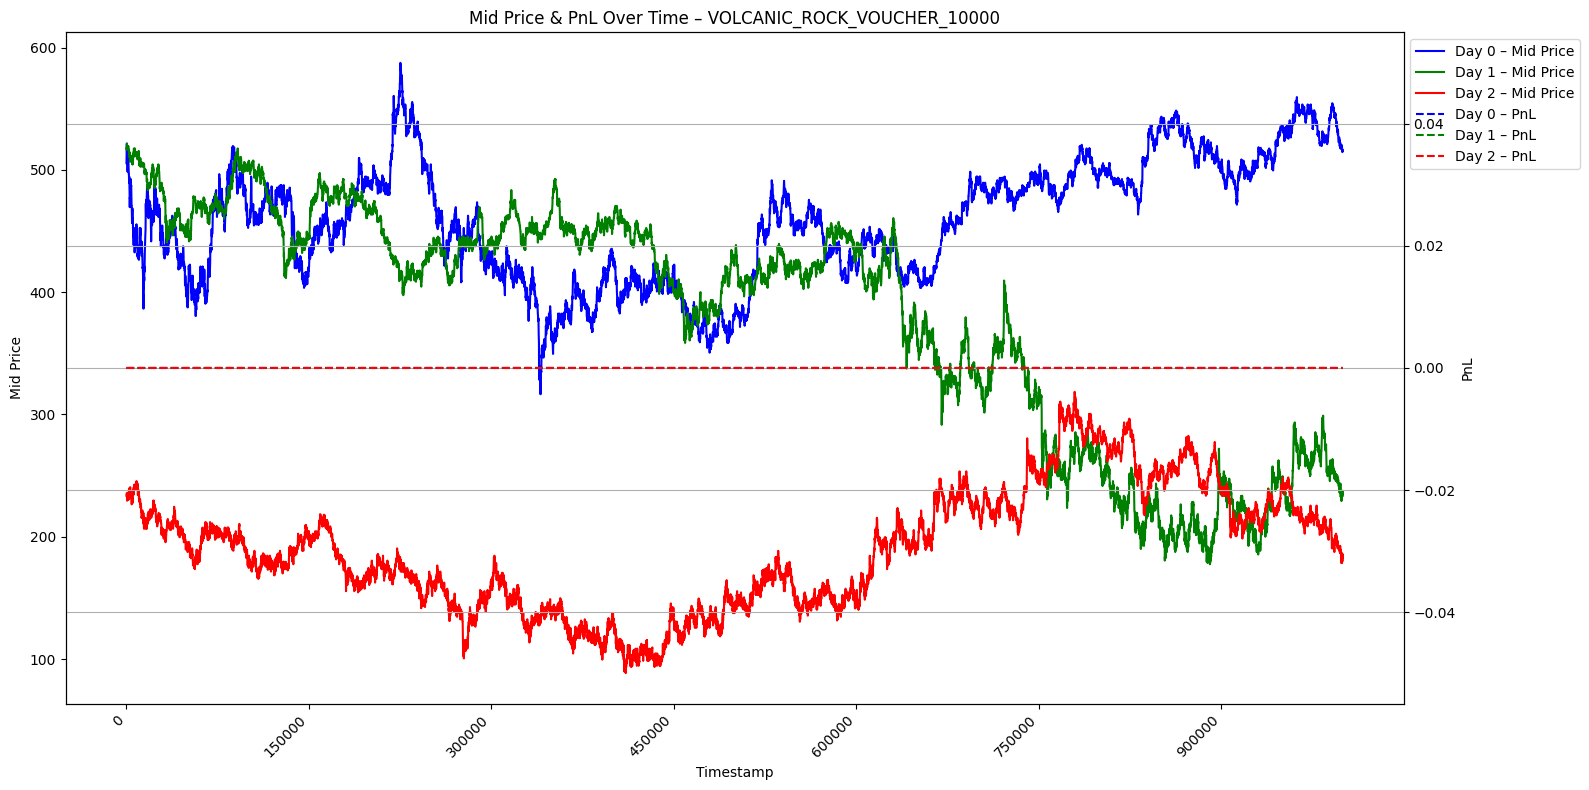

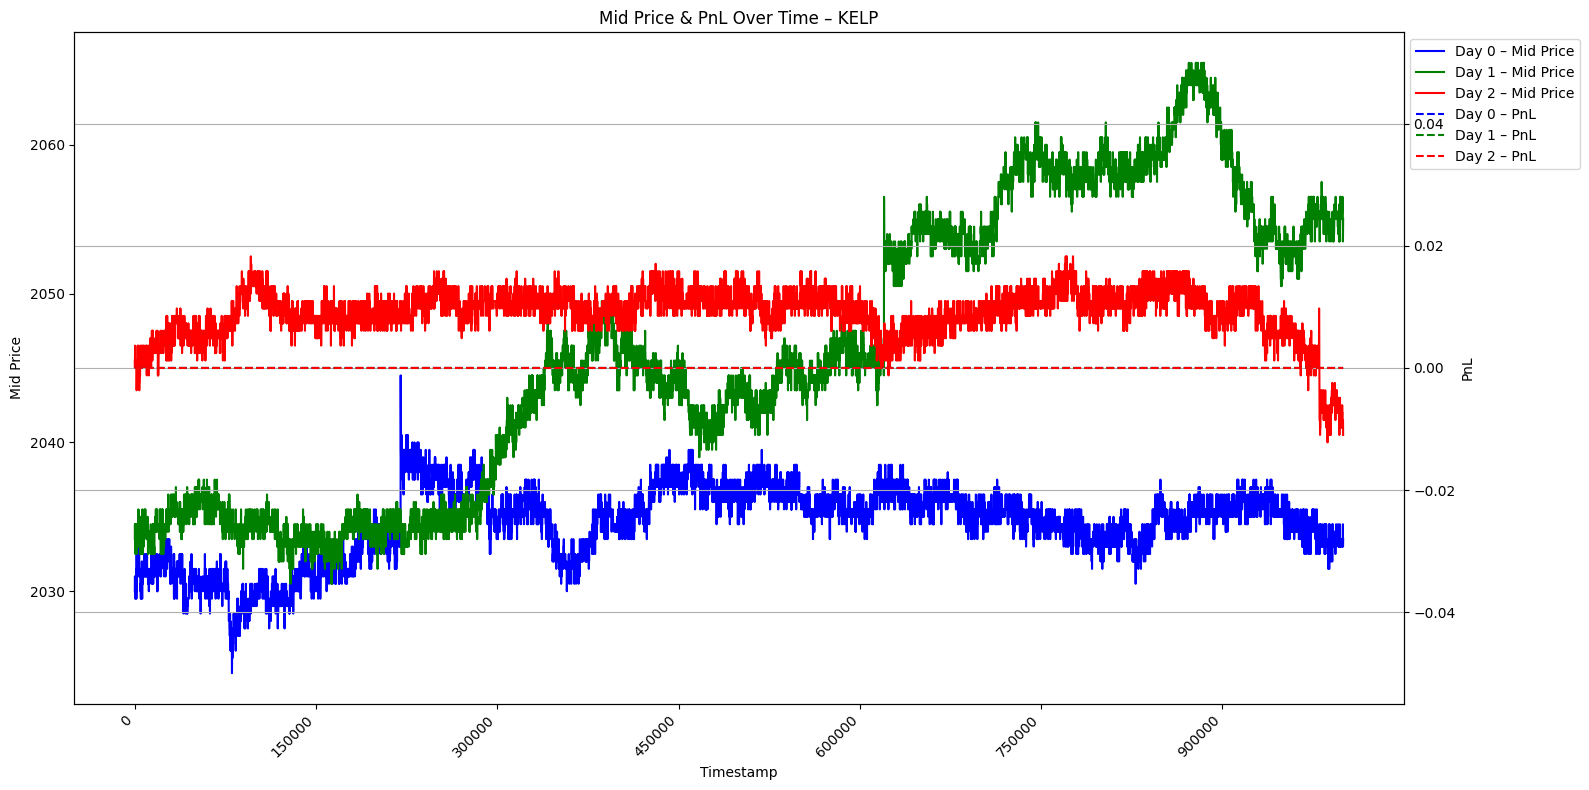

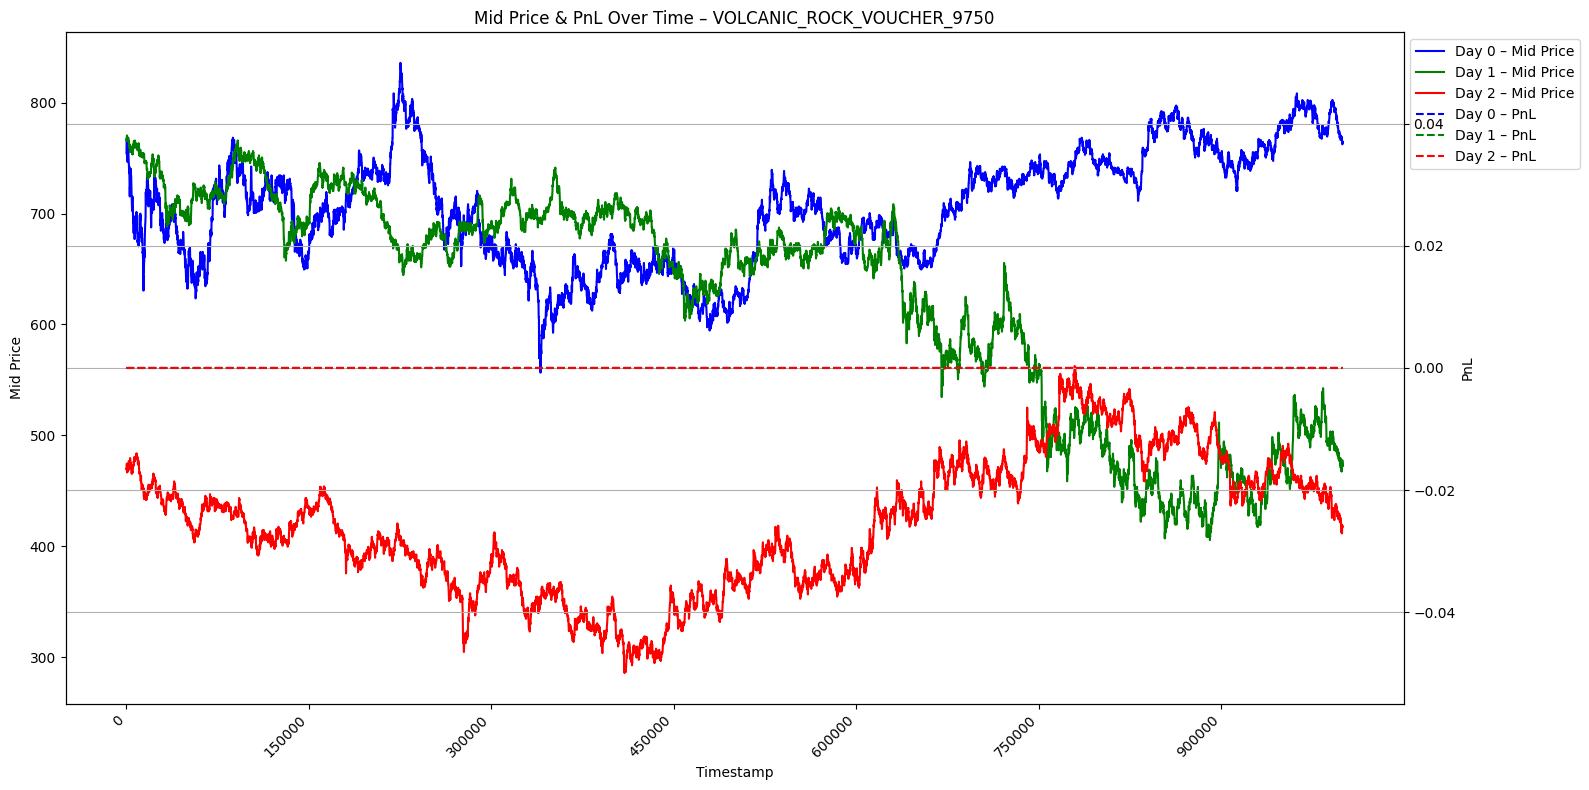

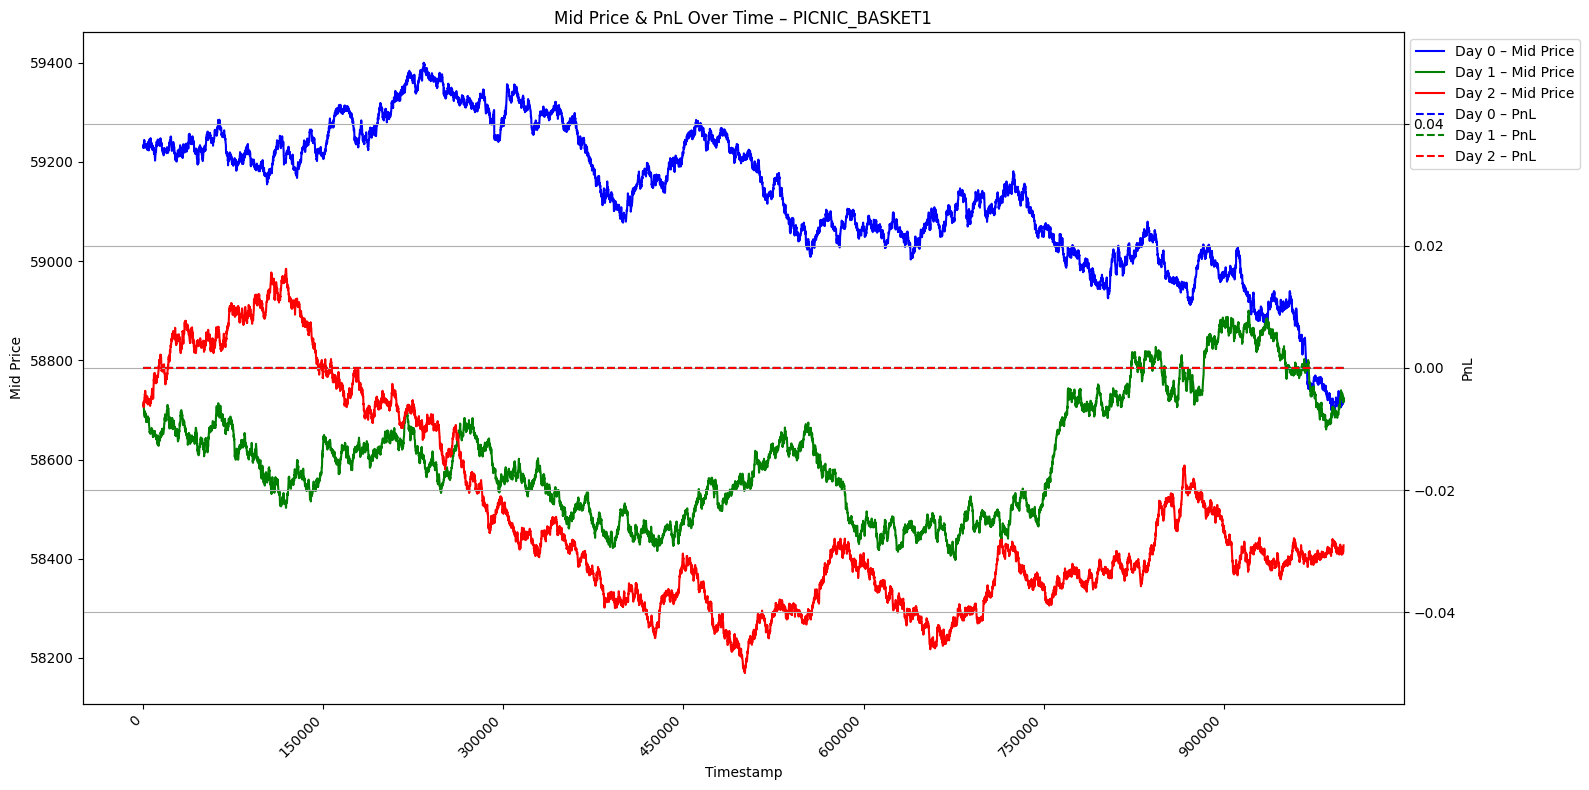

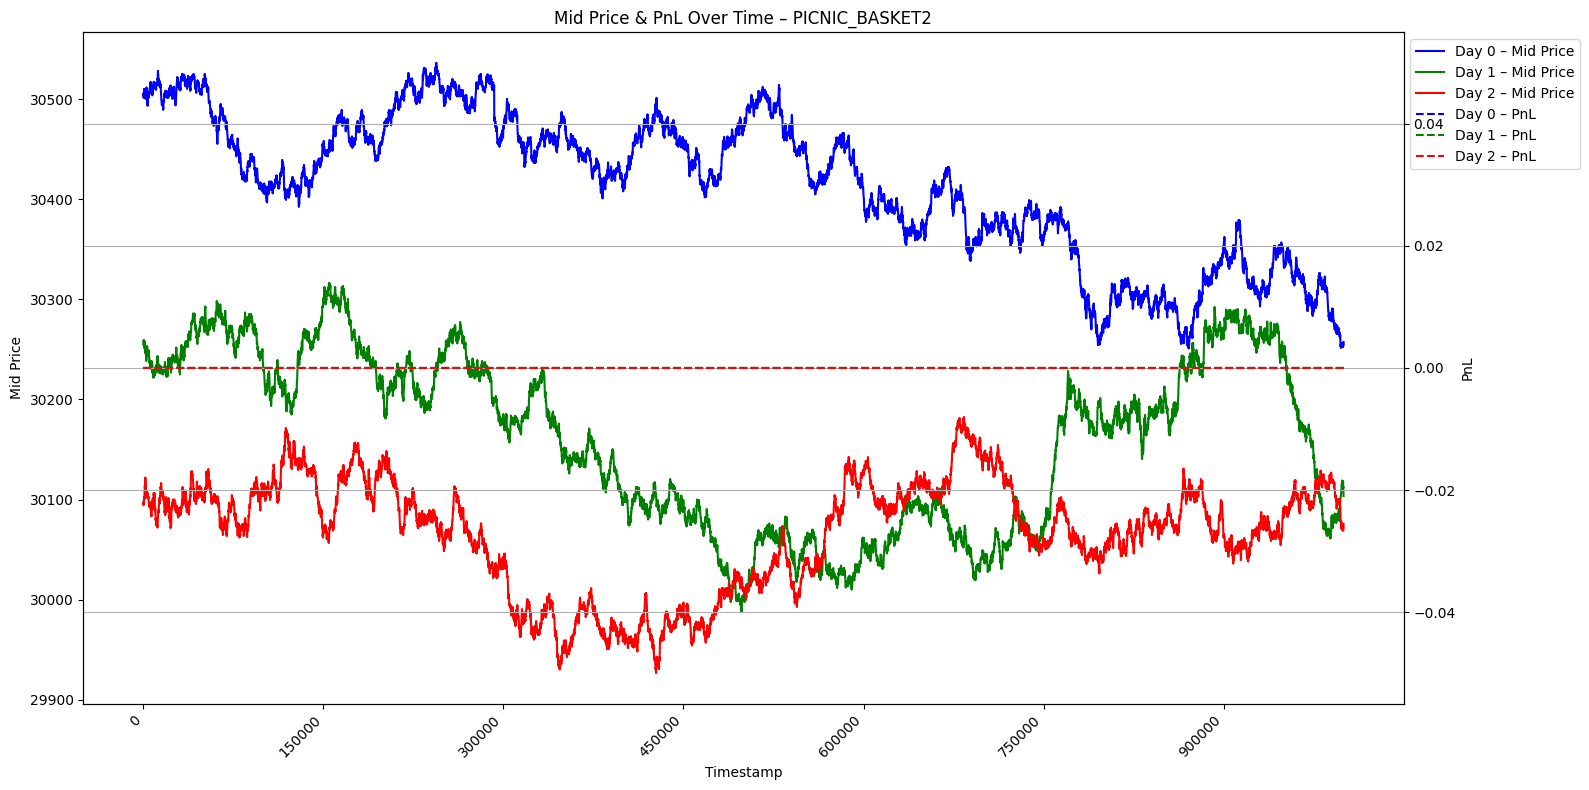

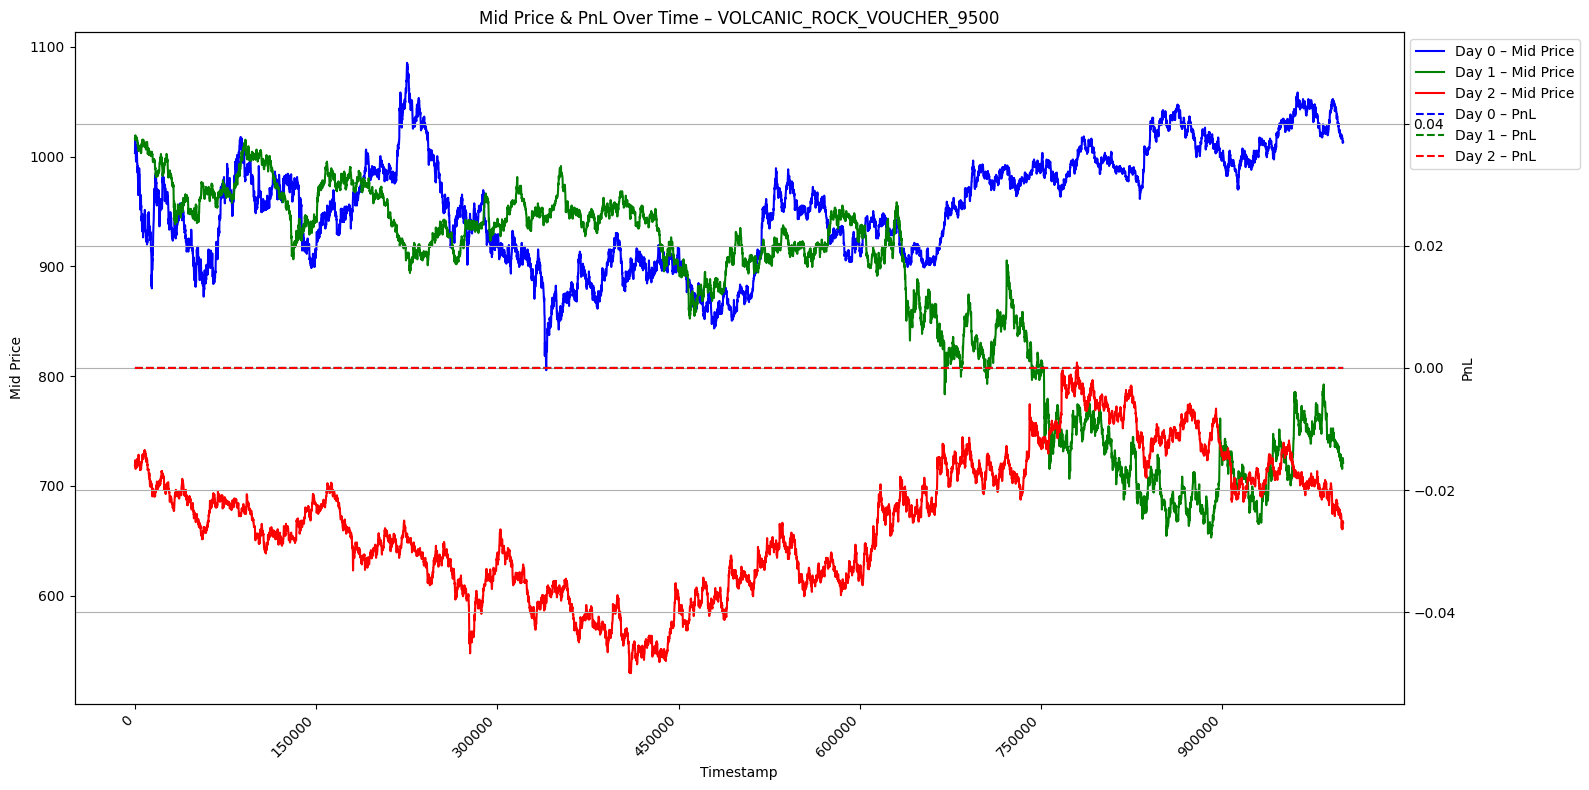

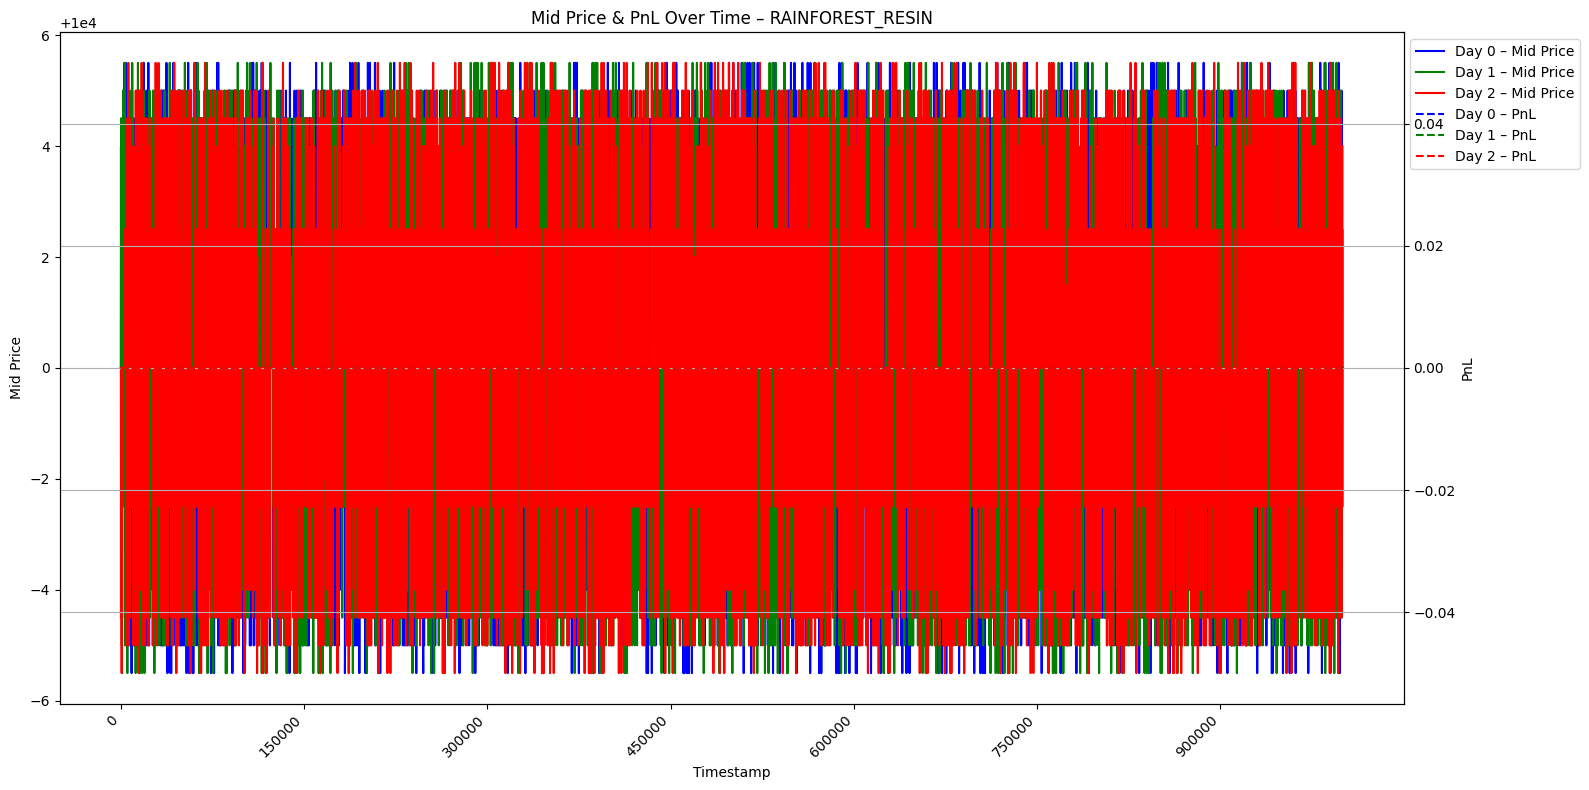

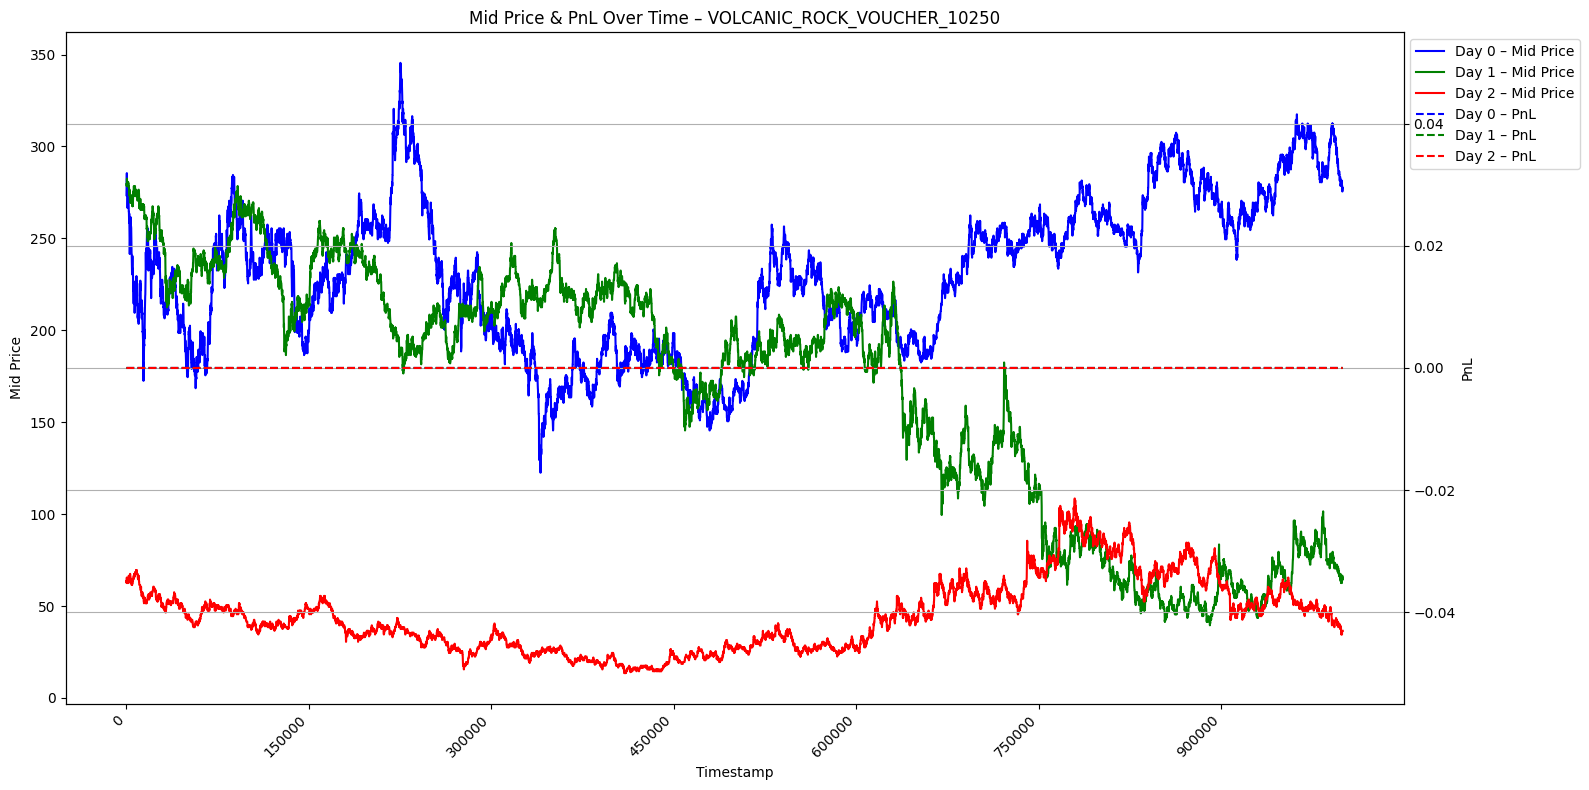

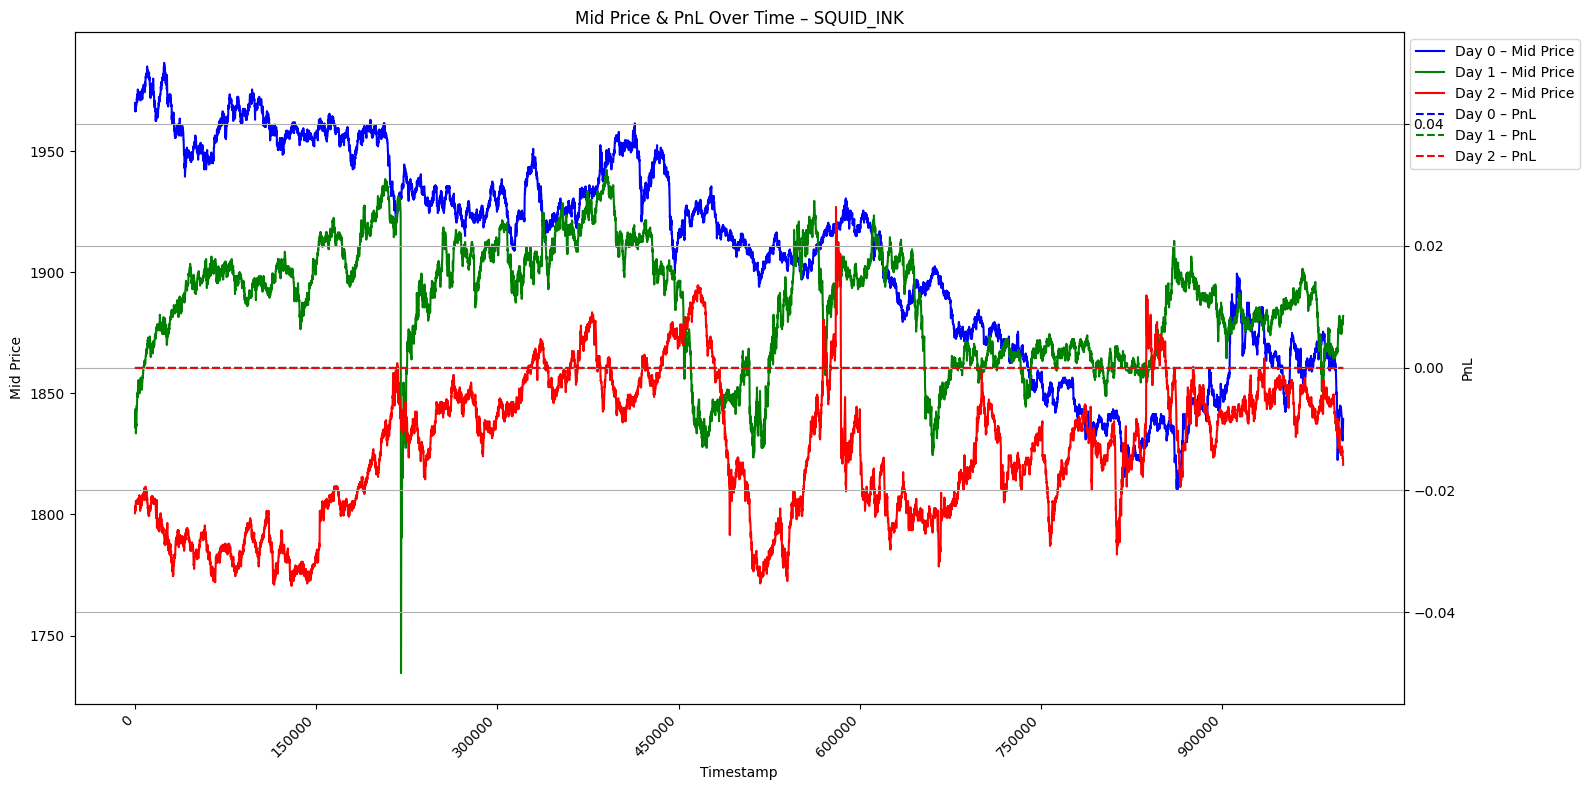

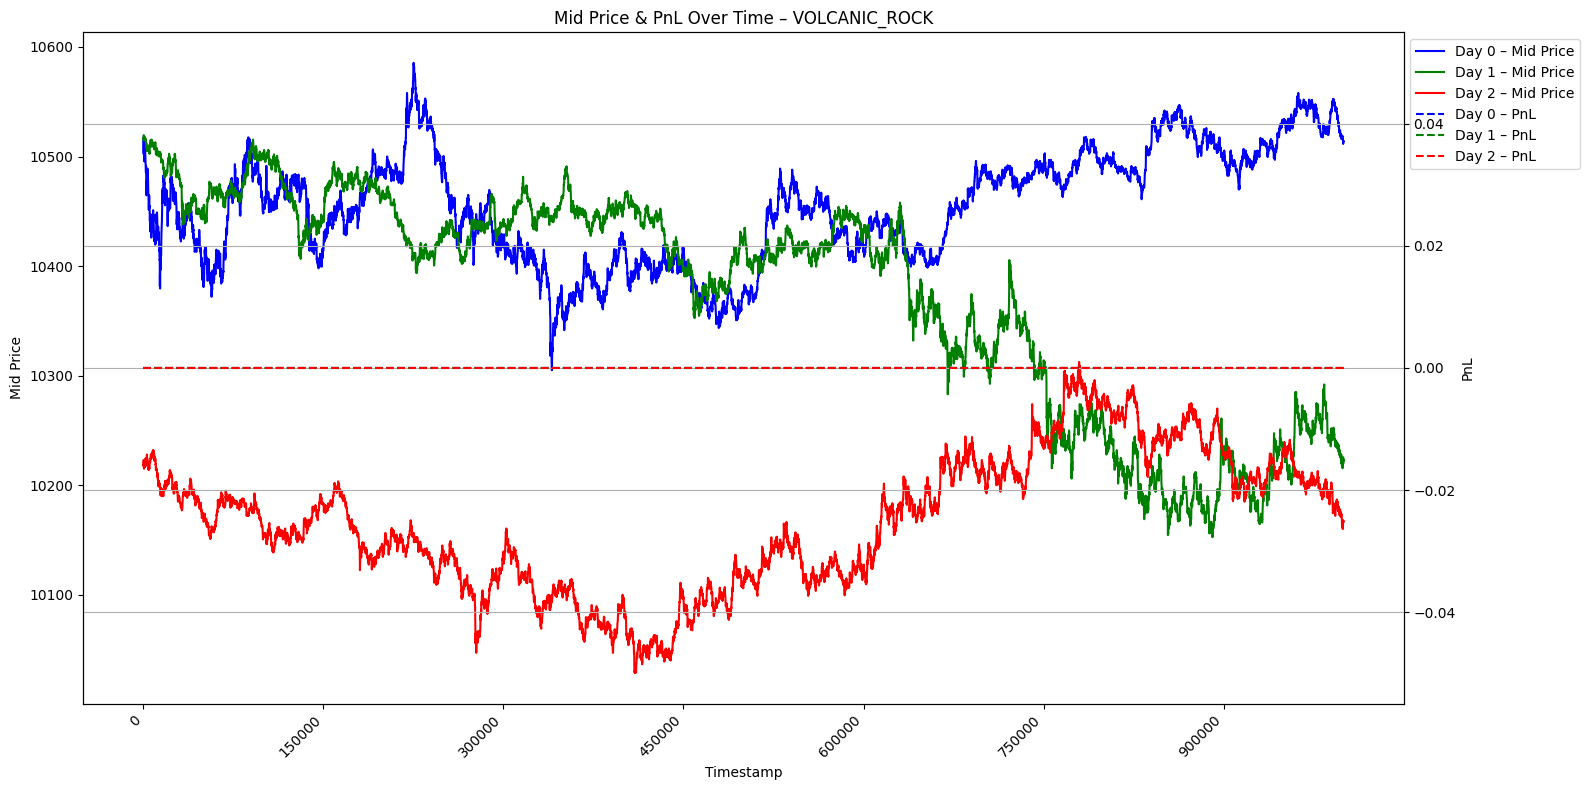

In [14]:
# Graphs (just PnL mappings—unchanged):
prices_df = load_all_days_prices(round_, days, root)
for product in prices_df['product'].unique():
    plot_prices_across_days(prices_df, product=product, days=days)

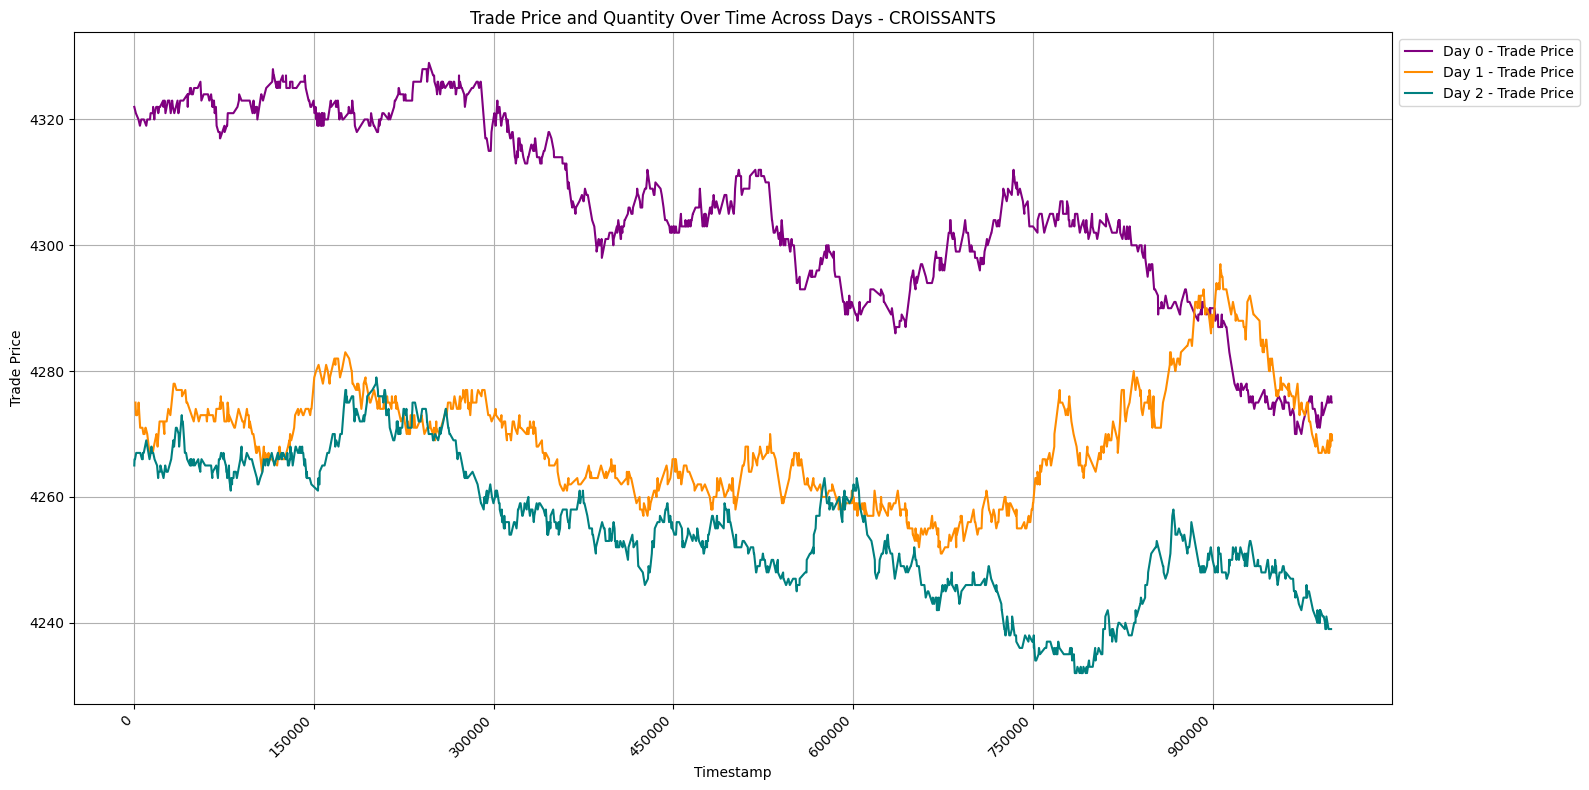

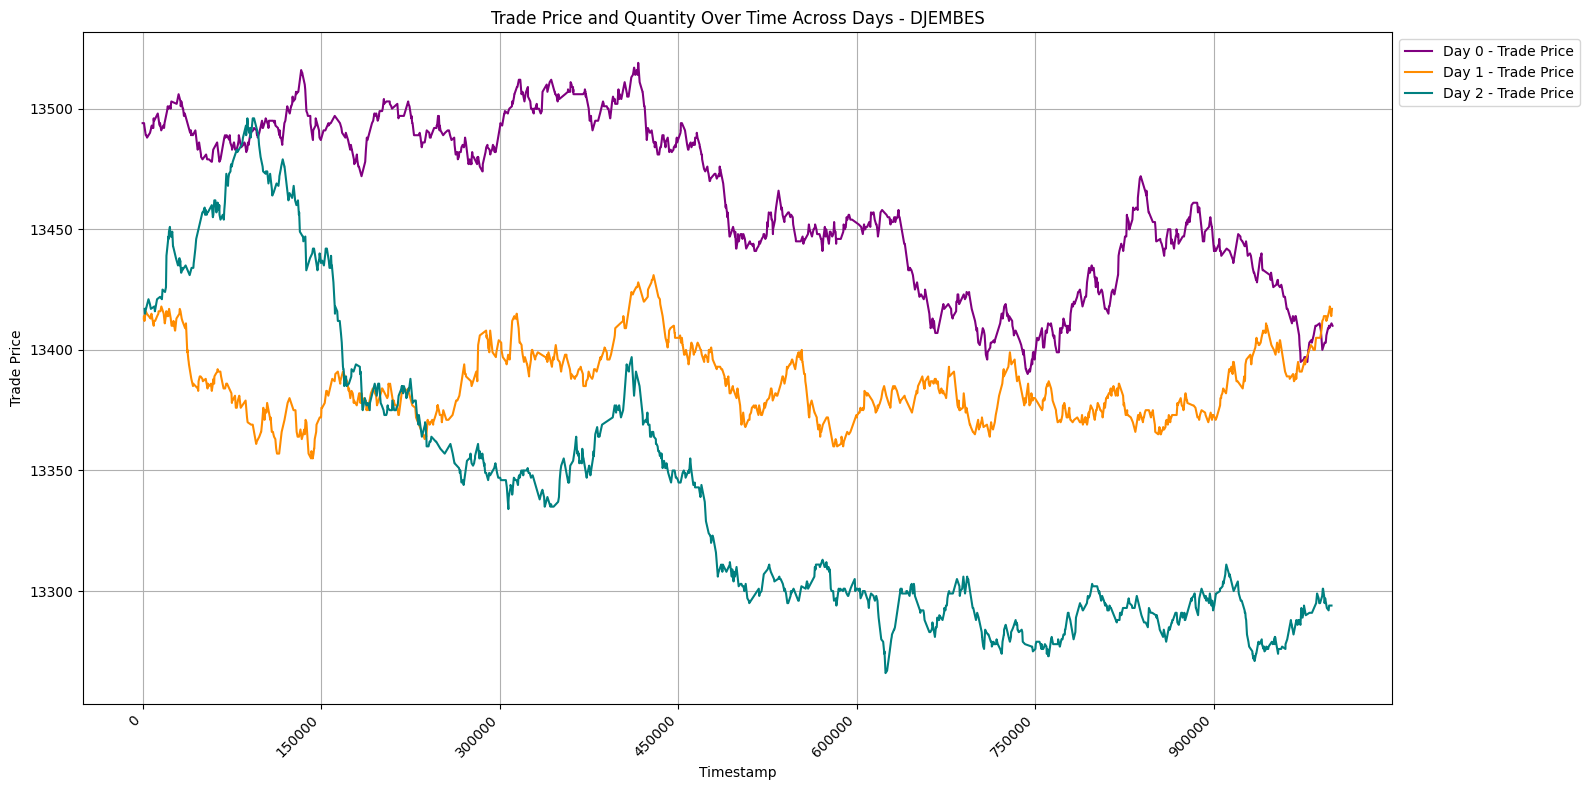

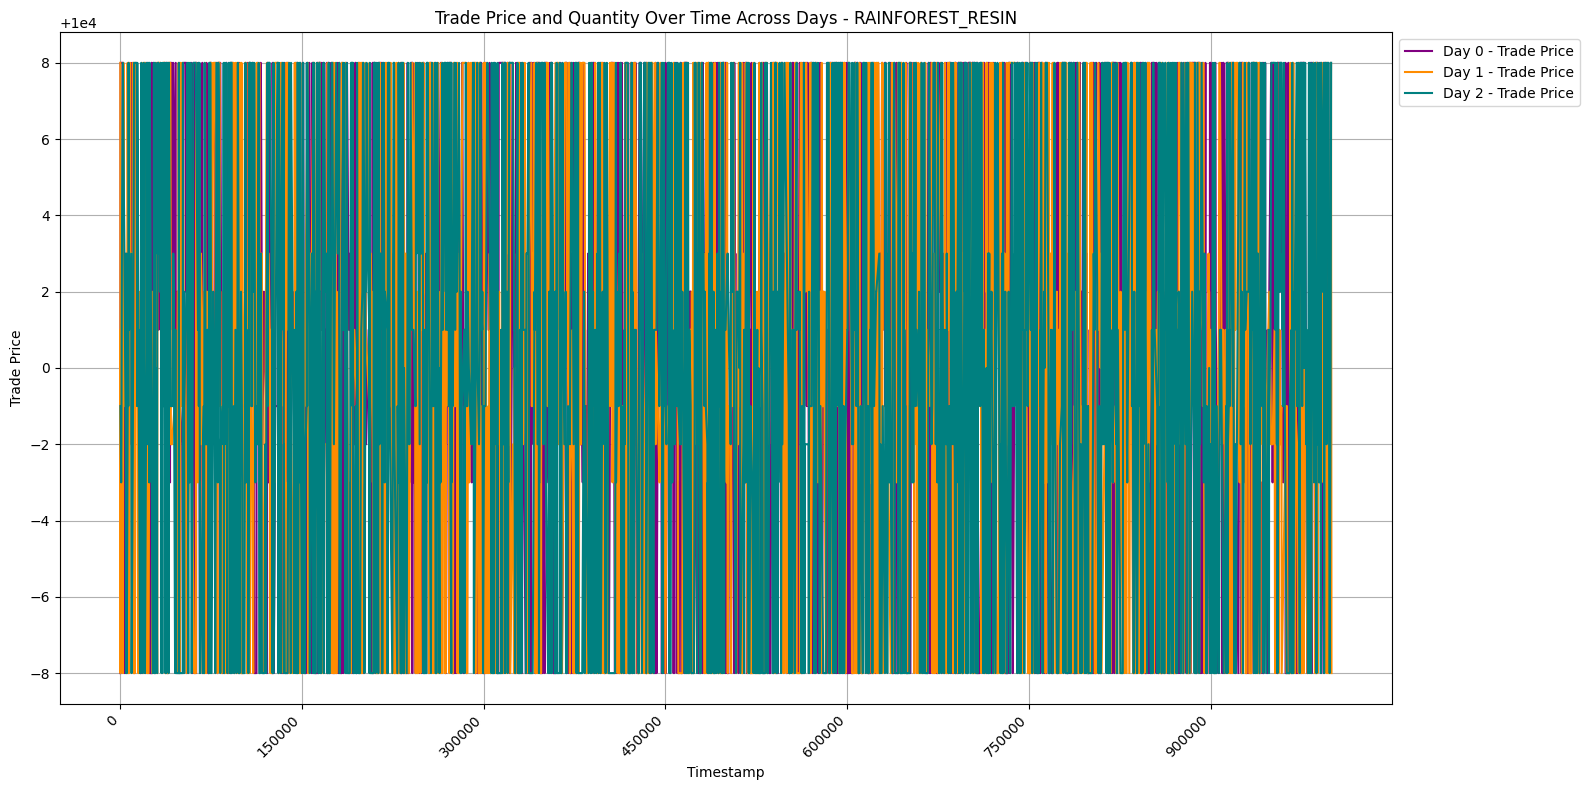

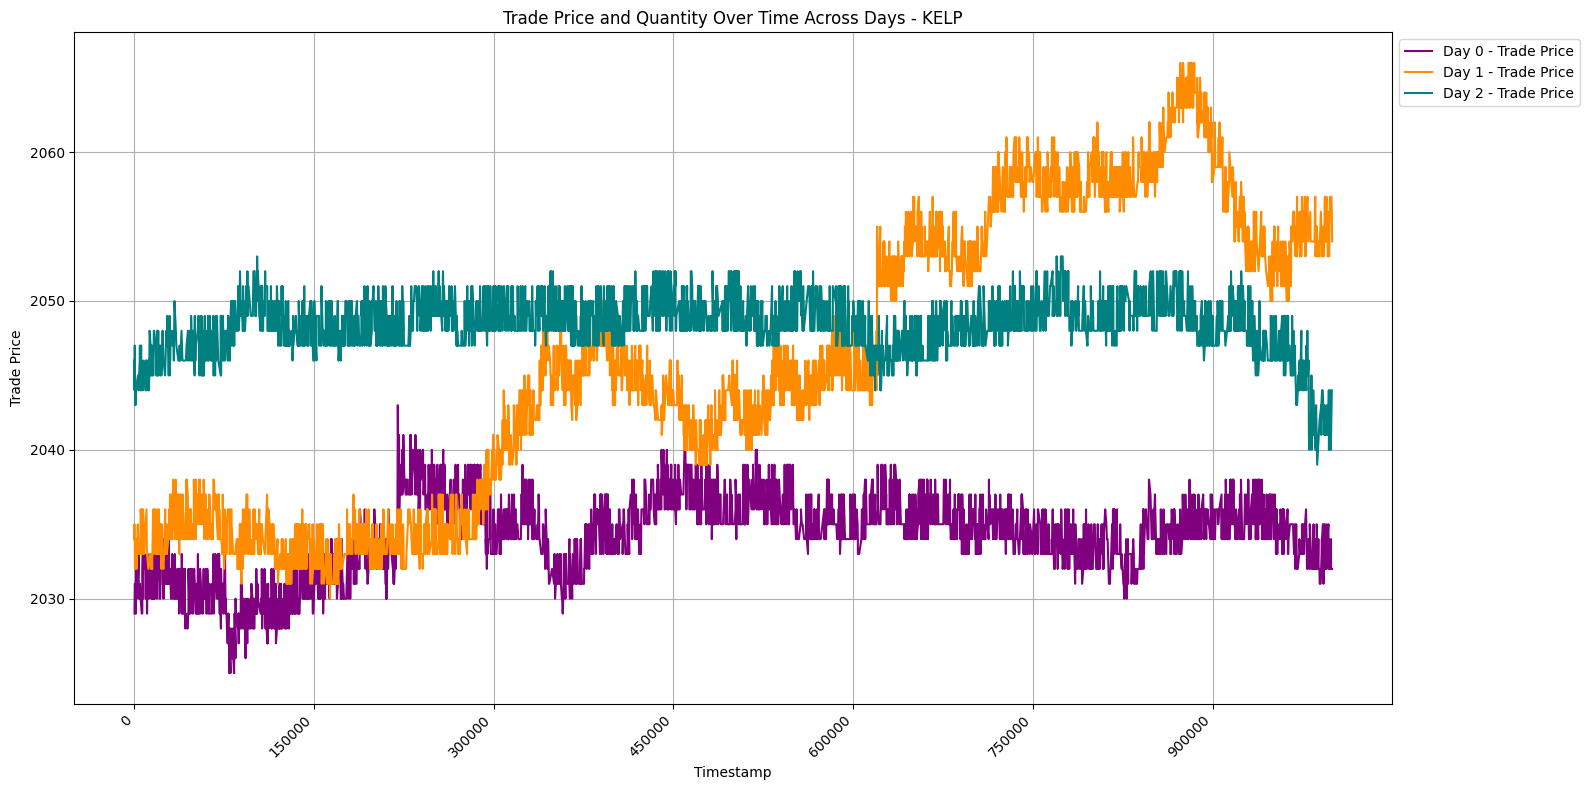

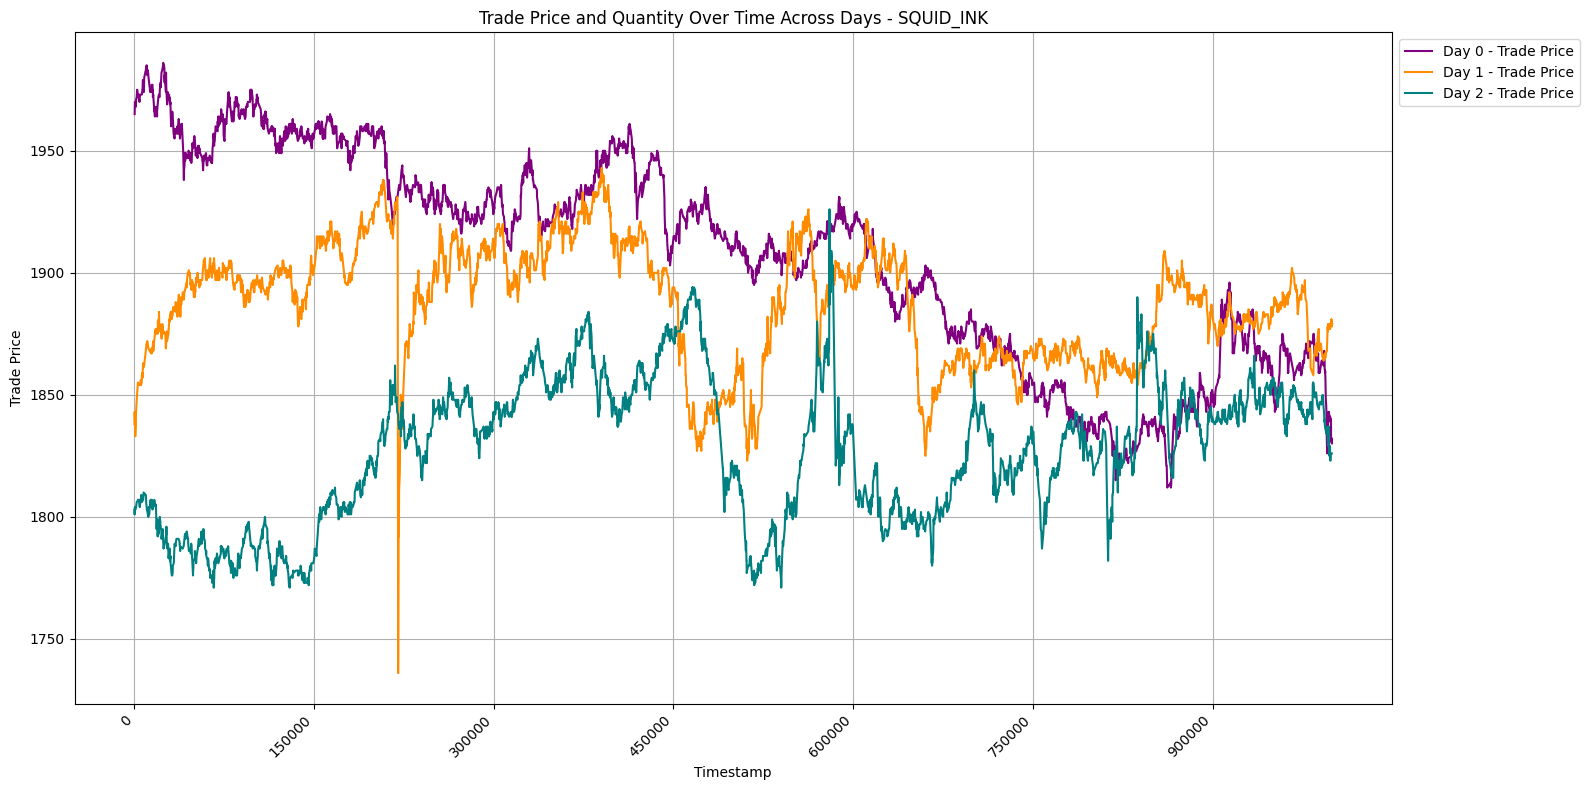

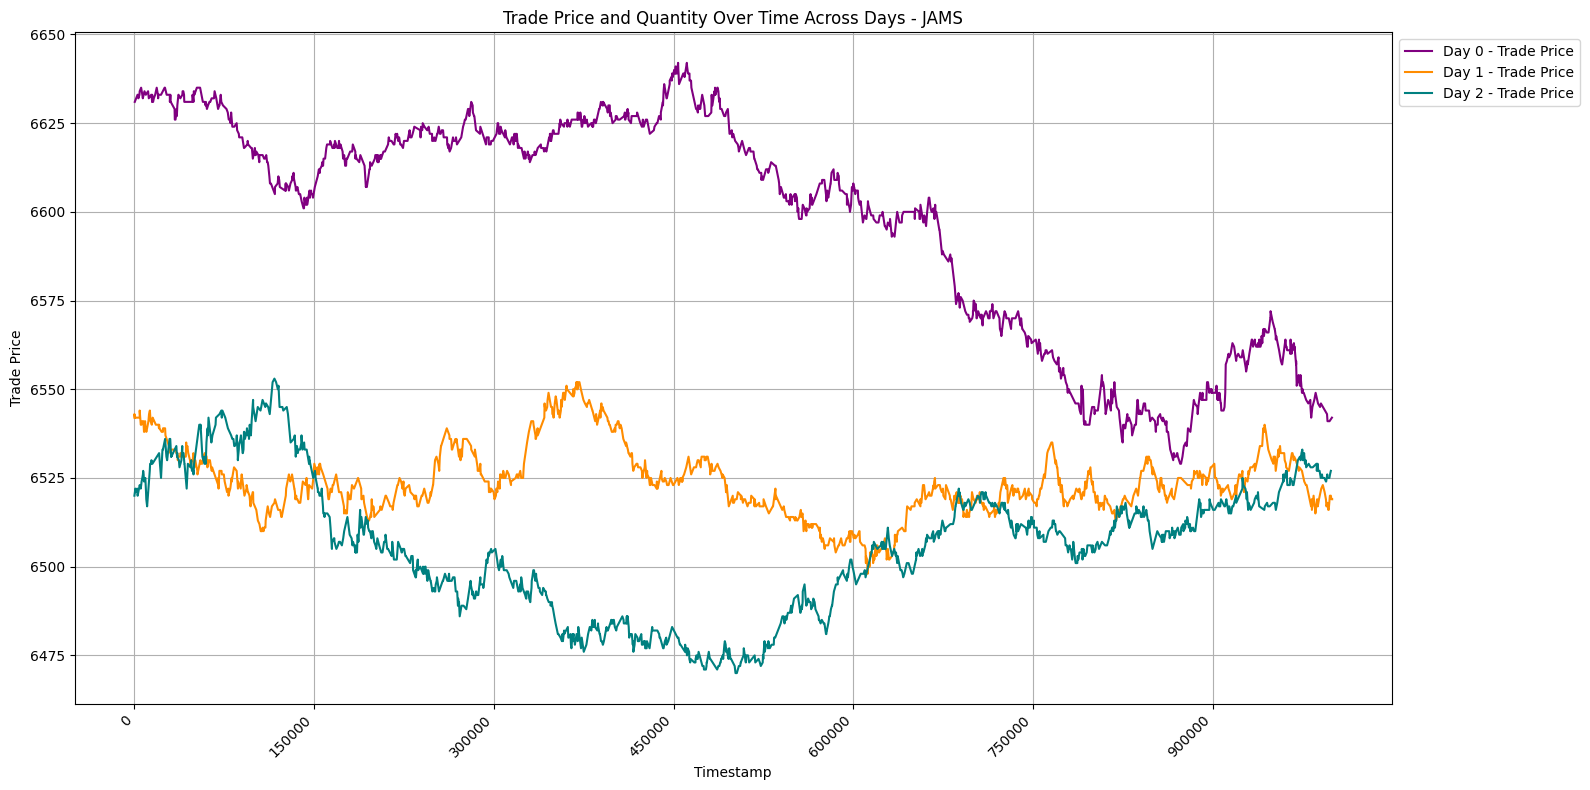

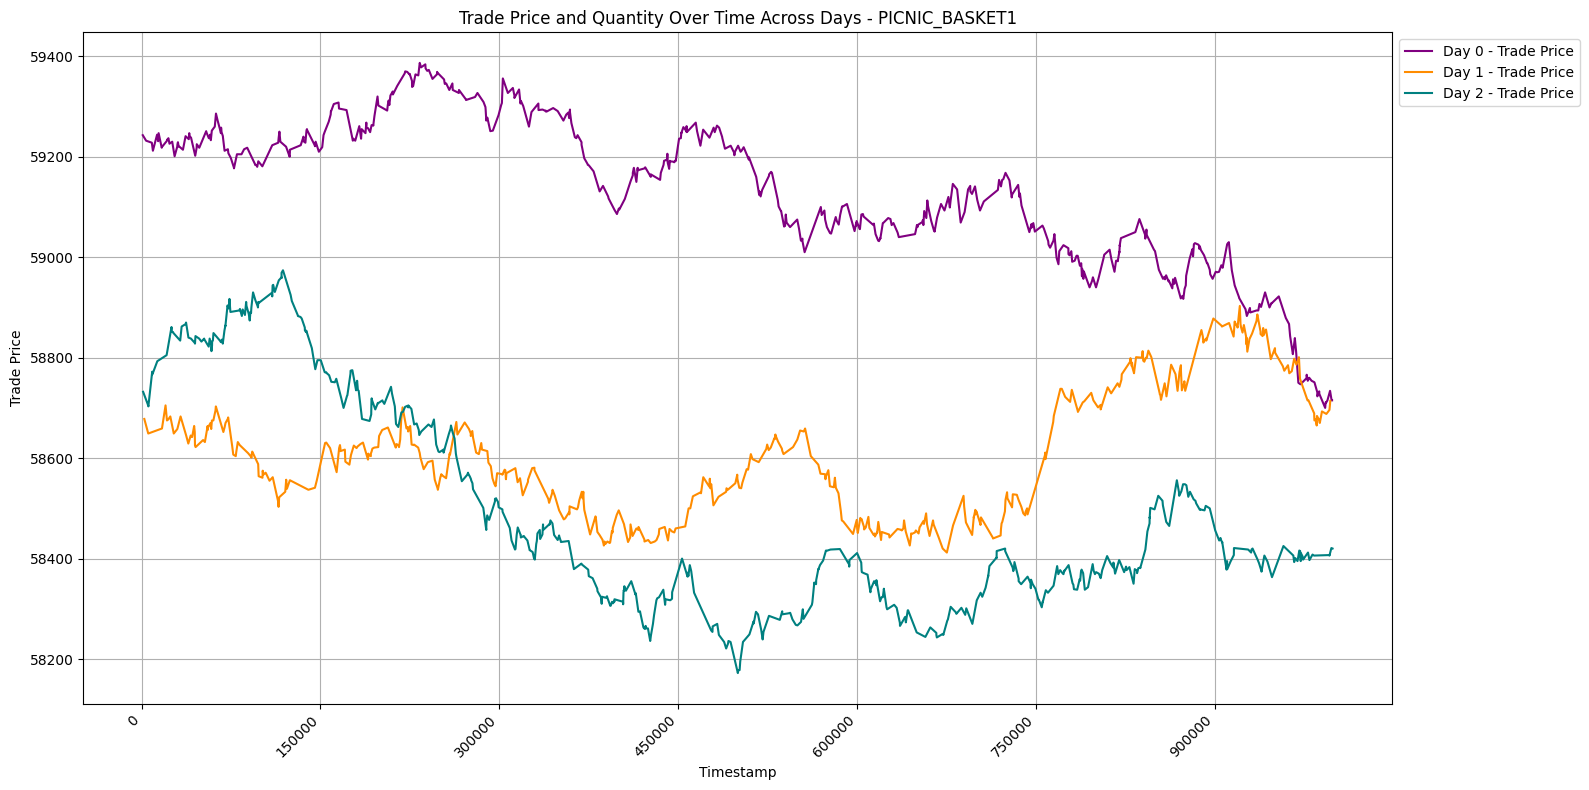

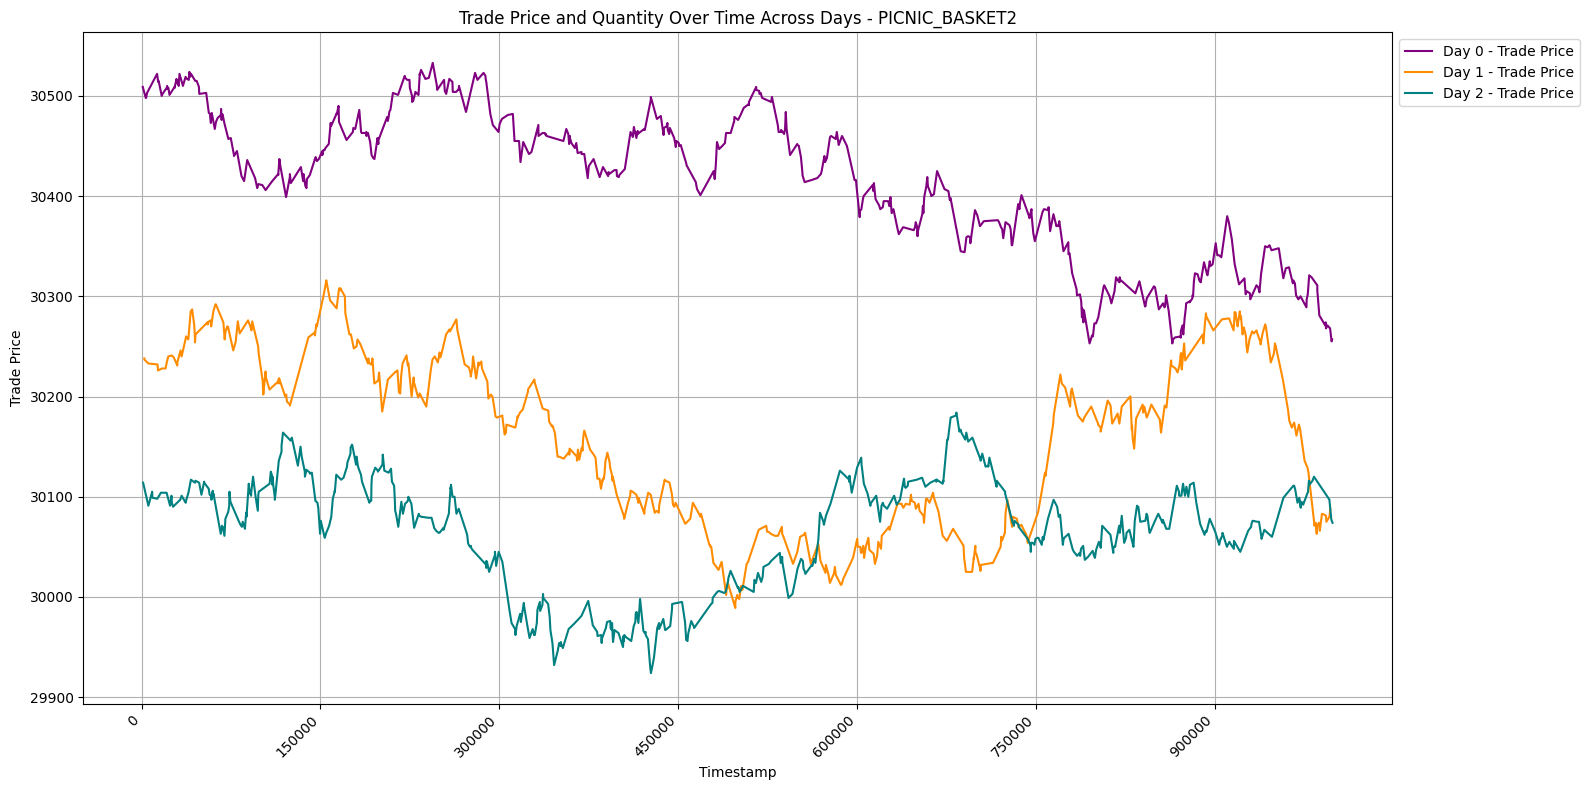

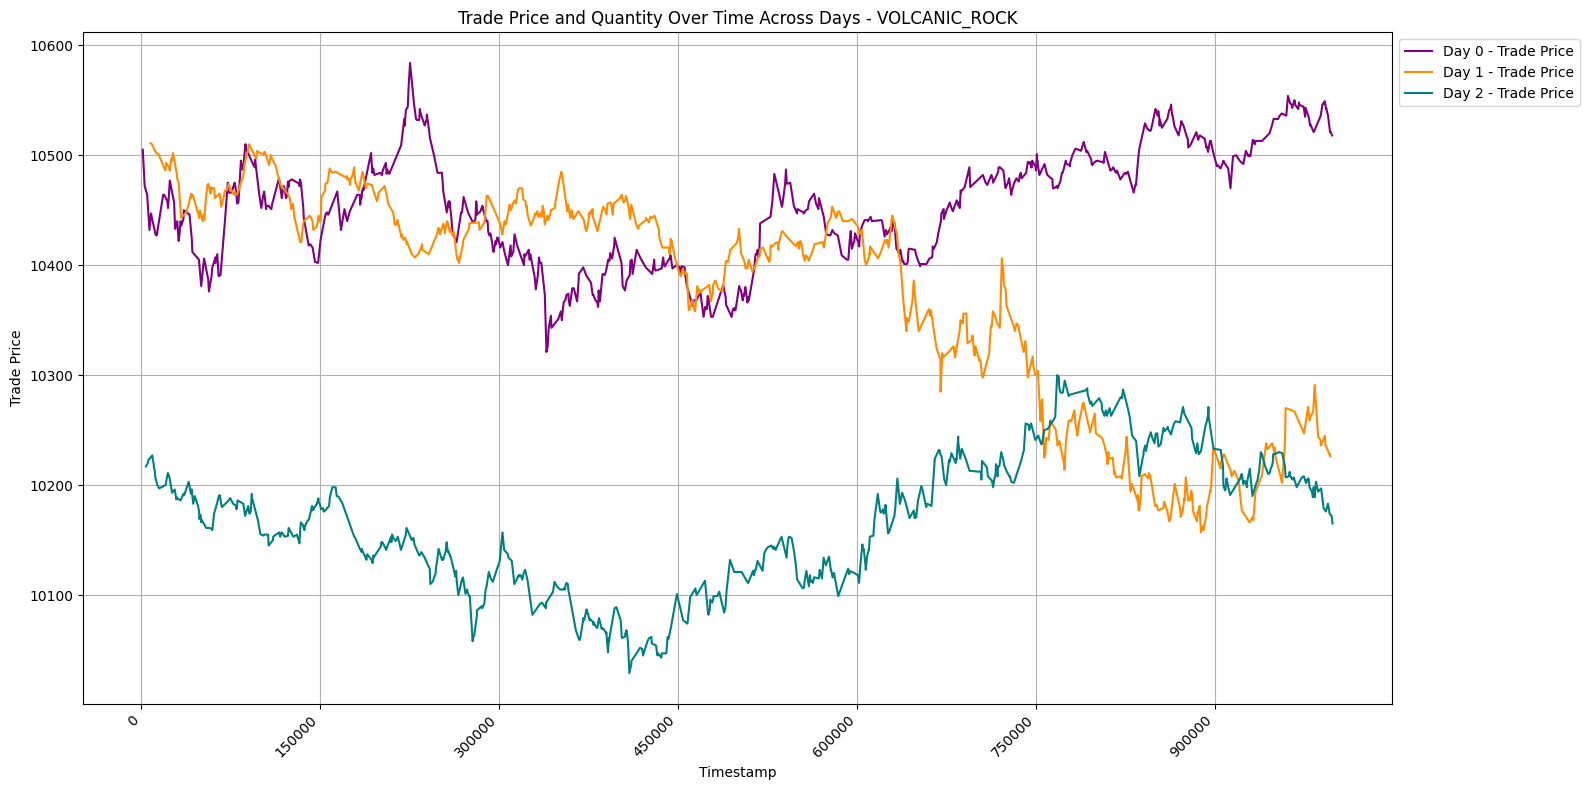

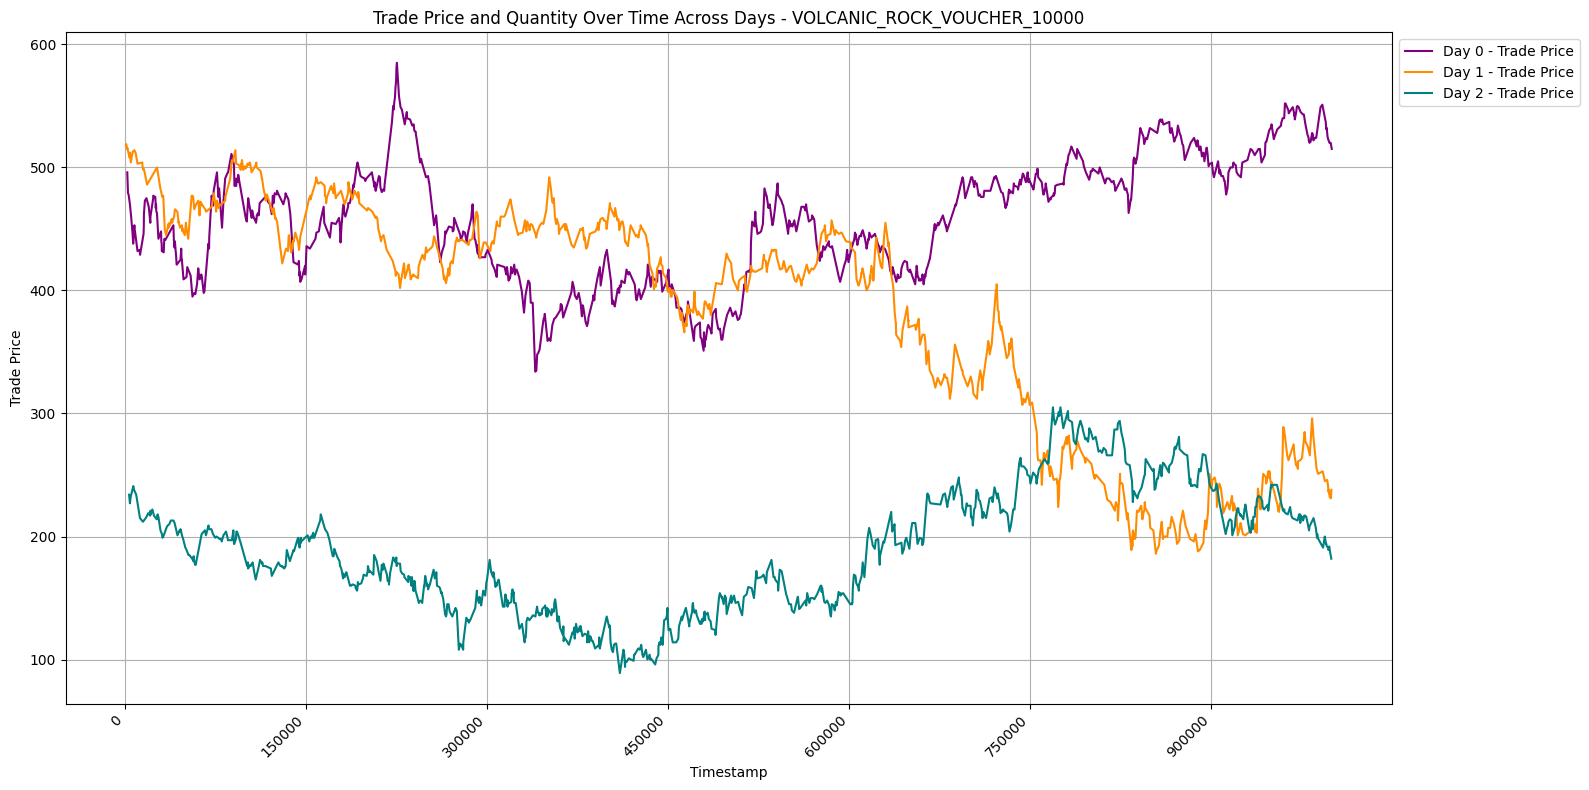

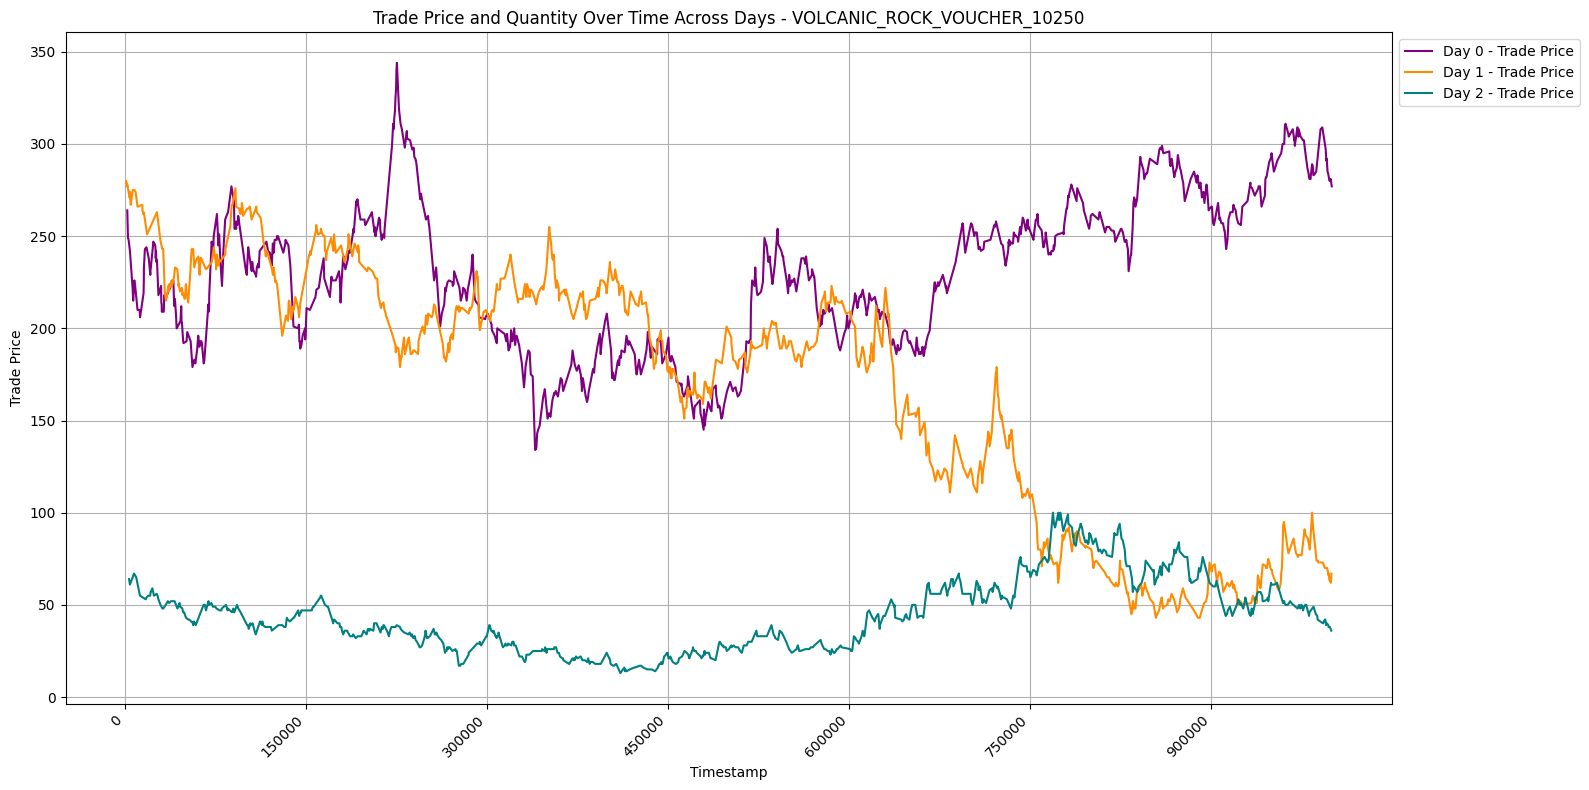

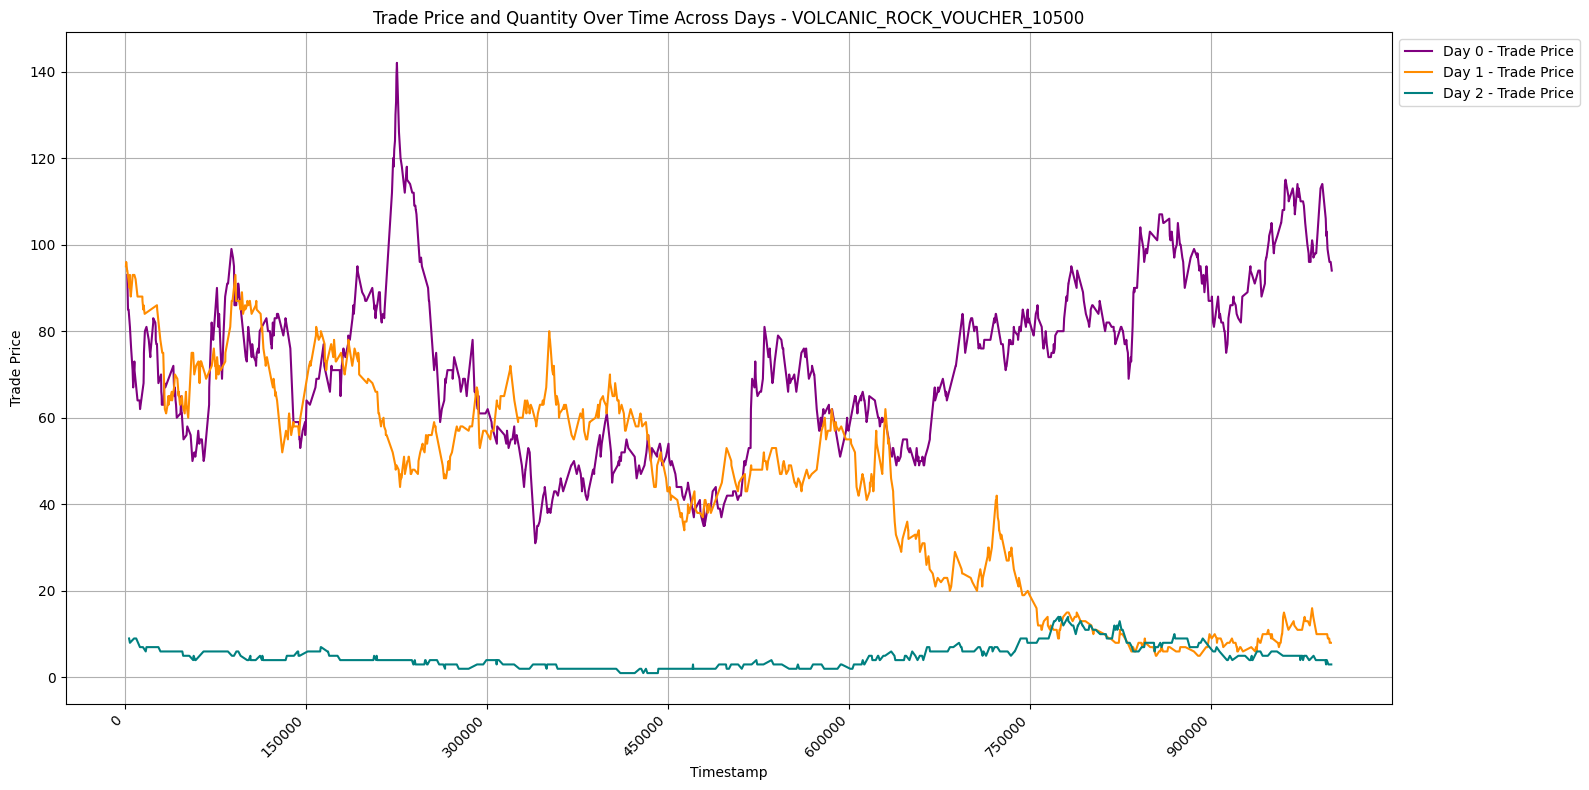

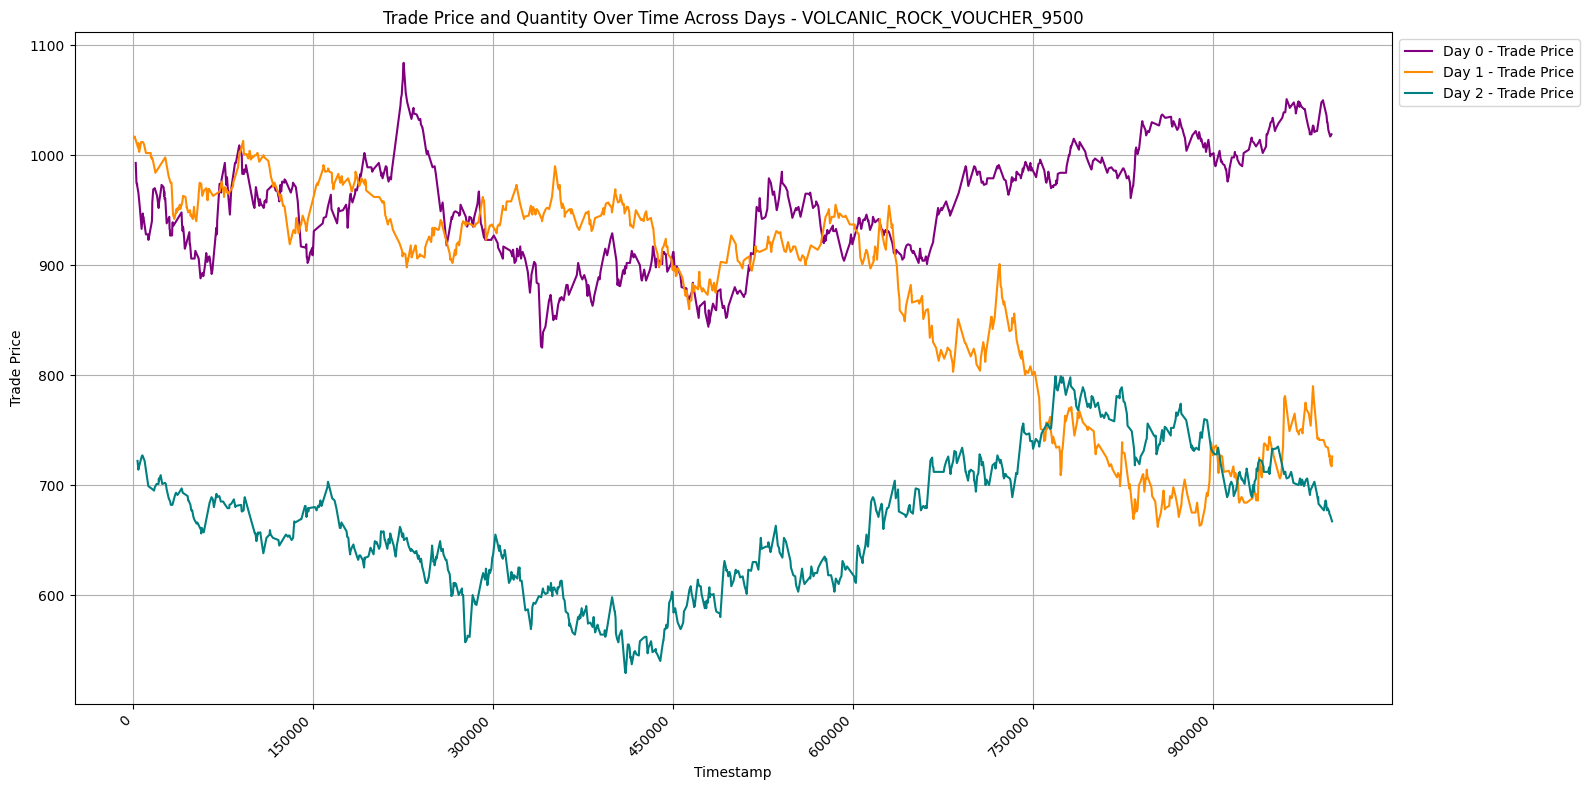

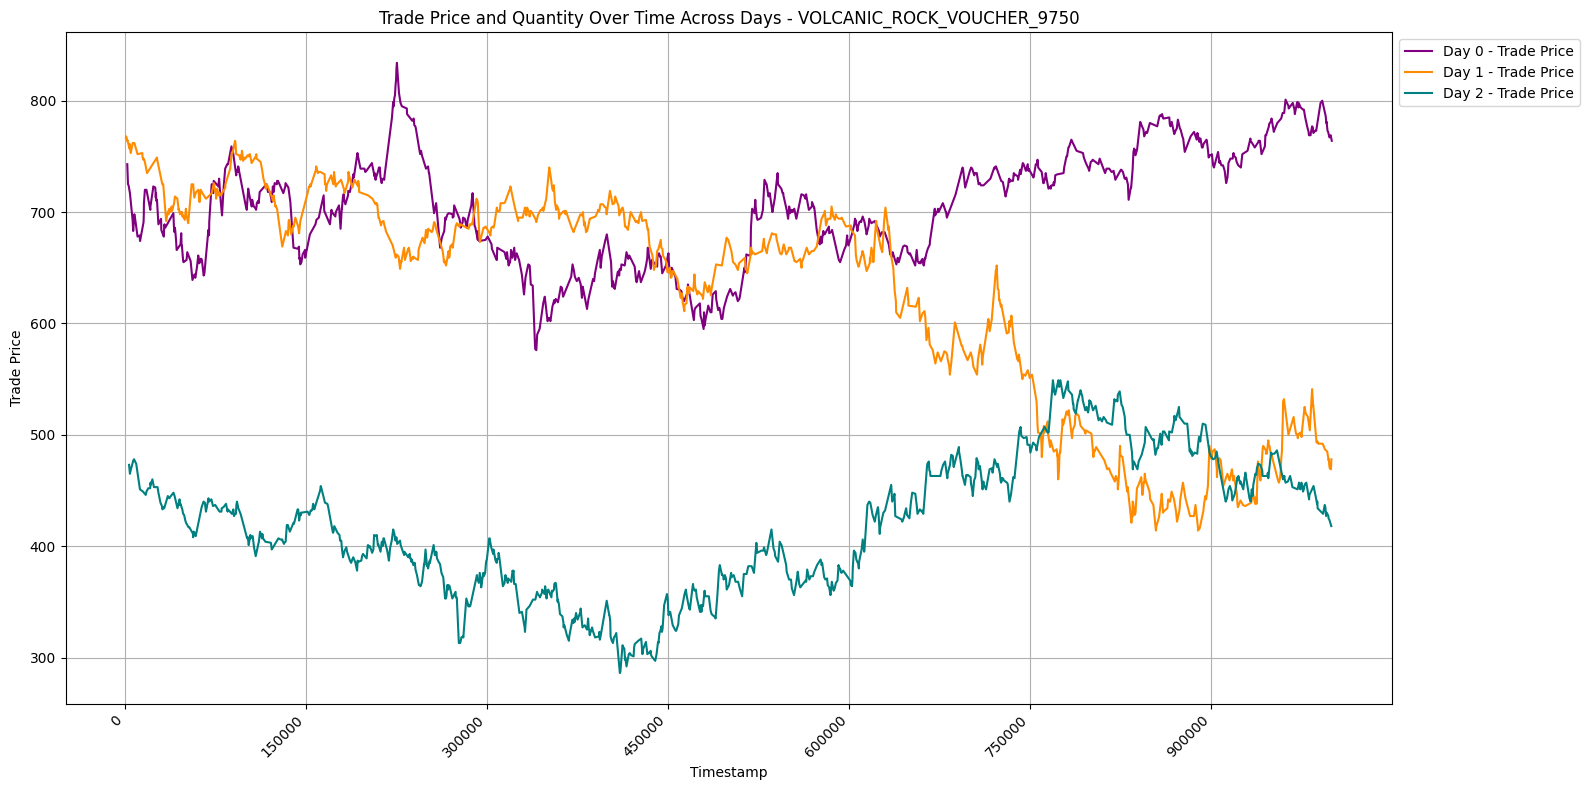

In [15]:
# Graphs (just PnL mappings—unchanged):
trades_df = load_all_days_trades(round_, days, root)
for product in trades_df['symbol'].unique():
    plot_trades_across_days(trades_df, product=product, days=days)

In [17]:
# Stats extraction:
raw_prices = load_all_days_prices(round_, days, root)
raw_trades = load_all_days_trades(round_, days, root)

pp = preprocess_prices(raw_prices)
pt = preprocess_trades(raw_trades)

price_stats = analyze_prices(pp)
trade_stats = analyze_trades(pt)

# Exporting combined stats across all days:
export_stats(price_stats, f'../../data/round-{round_}-island-data-bottle/price_stats_all_days.csv')
export_stats(trade_stats, f'../../data/round-{round_}-island-data-bottle/trade_stats_all_days.csv')

In [18]:
price_stats.head(15)

product  day     mean_mid     std_mid  min_mid  max_mid  \
0       CROISSANTS    0   4305.81475   14.863199   4269.5   4328.5   
1       CROISSANTS    1   4269.00945    9.078903   4251.0   4296.5   
2       CROISSANTS    2   4254.71995   10.686226   4232.0   4278.5   
3          DJEMBES    0  13462.41955   33.933198  13389.5  13519.5   
4          DJEMBES    1  13385.98110   14.916849  13353.0  13433.5   
5          DJEMBES    2  13340.50955   60.223413  13263.5  13498.5   
6             JAMS    0   6597.79005   31.926301   6529.0   6641.5   
7             JAMS    1   6524.04540    9.558477   6498.5   6552.5   
8             JAMS    2   6506.14450   19.178575   6470.0   6554.0   
9             KELP    0   2034.55160    2.420315   2024.5   2044.5   
10            KELP    1   2046.15235    9.566837   2030.5   2065.5   
11            KELP    2   2048.75010    1.568453   2040.0   2052.5   
12  PICNIC_BASKET1    0  59134.60080  144.668540  58689.5  59399.5   
13  PICNIC_BASKET1    1  58604.49380  118.379290  58397.5  58900.0   
14  PICNIC_BASKET1    2  58483.95170  202.656017  58169.5  58984.5   

    median_mid  skew_mid  kurtosis_mid  mean_spread  std_spread  \
0       4305.5 -0.435892     -0.579043       1.2051    0.403795   
1       4268.5  0.481753     -0.078836       1.2127    0.409238   
2       4253.5  0.048166     -0.727708       1.1995    0.399644   
3      13461.0 -0.329040     -1.163545       1.2705    0.444240   
4      13383.5  0.597854     -0.144486       1.2576    0.437334   
5      13309.5  0.935511     -0.238202       1.2653    0.441515   
6       6610.0 -0.654208     -1.074680       1.6311    0.482531   
7       6523.0  0.474776      0.428688       1.6148    0.486667   
8       6507.0  0.086928     -0.662821       1.6074    0.488353   
9       2035.0 -0.655234      0.061334       2.7292    0.882465   
10      2045.0  0.140023     -1.297693       2.7259    0.883203   
11      2049.0 -1.681770      4.965886       2.7382    0.895623   
12     59145.5 -0.594583      0.050605       9.2532    2.012187   
13     58595.0  0.476991     -0.591968       9.1758    1.989847   
14     58409.5  0.883172     -0.479851       9.1496    2.008089   

    realized_volatility  price_entry_count  
0              0.008687              10000  
1              0.009516              10000  
2              0.009382              10000  
3              0.006112              10000  
4              0.006428              10000  
5              0.007016              10000  
6              0.007821              10000  
7              0.008018              10000  
8              0.008194              10000  
9              0.038159              10000  
10             0.038017              10000  
11             0.037780              10000  
12             0.007043              10000  
13             0.007261              10000  
14             0.007265              10000

In [19]:
trade_stats.head(15)

product  day  trade_count  total_volume  mean_trade_price  \
0       CROISSANTS    0          988          6571       4305.513158   
1       CROISSANTS    1          973          6468       4268.932169   
2       CROISSANTS    2          989          6556       4254.567240   
3          DJEMBES    0         1091          3620      13461.672777   
4          DJEMBES    1          992          3427      13385.990927   
5          DJEMBES    2         1016          3454      13340.678150   
6             JAMS    0         1174          8266       6597.413118   
7             JAMS    1         1142          8165       6523.604203   
8             JAMS    2         1165          8144       6505.589700   
9             KELP    0         2876          8283       2034.046245   
10            KELP    1         2987          8302       2045.915969   
11            KELP    2         2899          8437       2048.353570   
12  PICNIC_BASKET1    0          590          1970      59133.855932   
13  PICNIC_BASKET1    1          542          1862      58604.726937   
14  PICNIC_BASKET1    2          611          2120      58499.738134   

    median_trade_price  std_trade_price  min_trade_price  max_trade_price  \
0               4305.0        14.742258           4270.0           4329.0   
1               4269.0         9.311456           4251.0           4297.0   
2               4254.0        10.742419           4232.0           4279.0   
3              13458.0        33.681539          13390.0          13519.0   
4              13384.0        14.824943          13355.0          13431.0   
5              13310.0        61.186413          13266.0          13496.0   
6               6609.0        32.105493           6529.0           6642.0   
7               6522.5         9.974336           6498.0           6552.0   
8               6507.0        18.781660           6470.0           6553.0   
9               2034.0         2.719006           2025.0           2043.0   
10              2045.0         9.610044           2030.0           2066.0   
11              2048.0         1.951145           2039.0           2053.0   
12             59160.0       146.867673          58700.0          59387.0   
13             58597.5       121.594213          58412.0          58903.0   
14             58412.0       212.441715          58172.0          58974.0   

            vwap  mean_trade_size  median_trade_size  std_trade_size  \
0    4305.678283         6.650810                7.0        1.377386   
1    4268.882189         6.647482                7.0        1.412061   
2    4254.485662         6.628918                7.0        1.445646   
3   13461.752210         3.318057                3.0        1.883447   
4   13385.918879         3.454637                3.0        2.018071   
5   13338.418066         3.399606                3.0        1.900417   
6    6597.907936         7.040886                7.0        2.258268   
7    6523.637110         7.149737                7.0        2.316612   
8    6505.491405         6.990558                7.0        2.314770   
9    2034.131836         2.880042                1.0        3.429063   
10   2045.923994         2.779377                1.0        3.223096   
11   2048.605903         2.910314                1.0        3.416493   
12  59133.278173         3.338983                2.0        2.561370   
13  58603.338883         3.435424                2.0        2.667404   
14  58501.220283         3.469722                2.0        2.651381   

    max_trade_size  mean_inter_arrival_s  std_inter_arrival_s  
0               10           1011.336032           991.541244  
1               10           1026.413155          1003.487326  
2               10           1009.908999           929.434818  
3               11            916.406966           869.860431  
4               11           1006.350806           974.958919  
5               11            981.496063           963.998307  
6               12      

# Round 4

### EDA

In [23]:
observations_df = pd.read_csv('../../data/round-4-island-data-bottle/observations_round_4_day_1.csv', sep=',')
prices_df = pd.read_csv('../../data/round-4-island-data-bottle/prices_round_4_day_1.csv', sep=';')
trades_df = pd.read_csv('../../data/round-4-island-data-bottle/trades_round_4_day_1.csv', sep=';')

In [24]:
observations_df.head()

timestamp  bidPrice  askPrice  transportFees  exportTariff  importTariff  \
0          0     627.0     628.5            1.0           9.0          -3.0   
1        100     630.0     631.5            1.0           9.0          -3.0   
2        200     630.0     631.5            1.0           9.0          -3.0   
3        300     632.0     633.5            1.0           9.0          -3.0   
4        400     630.5     632.0            1.0           9.0          -3.0   

   sugarPrice  sunlightIndex  
0  200.000000          60.00  
1  200.098445          60.00  
2  200.103915          60.00  
3  200.352462          60.01  
4  200.201545          60.01

In [25]:
prices_df.head()

day  timestamp                     product  bid_price_1  bid_volume_1  \
0    1          0               VOLCANIC_ROCK      10515.0         143.0   
1    1          0              PICNIC_BASKET1      58705.0          12.0   
2    1          0              PICNIC_BASKET2      30252.0          12.0   
3    1          0  VOLCANIC_ROCK_VOUCHER_9500       1015.0          12.0   
4    1          0  VOLCANIC_ROCK_VOUCHER_9750        766.0          12.0   

   bid_price_2  bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  \
0      10514.0          57.0          NaN           NaN        10517   
1      58704.0          27.0          NaN           NaN        58716   
2      30251.0          27.0          NaN           NaN        30258   
3          NaN           NaN          NaN           NaN         1017   
4          NaN           NaN          NaN           NaN          767   

   ask_volume_1  ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  \
0           200          NaN           NaN          NaN           NaN   
1            12      58717.0          27.0          NaN           NaN   
2            39          NaN           NaN          NaN           NaN   
3            12          NaN           NaN          NaN           NaN   
4            12          NaN           NaN          NaN           NaN   

   mid_price  profit_and_loss  
0    10516.0              0.0  
1    58710.5              0.0  
2    30255.0              0.0  
3     1016.0              0.0  
4      766.5              0.0

In [26]:
trades_df.head()

timestamp  buyer  seller            symbol   currency    price  quantity
0          0    NaN     NaN  RAINFOREST_RESIN  SEASHELLS  10008.0         6
1        100    NaN     NaN              KELP  SEASHELLS   2034.0         1
2        100    NaN     NaN  RAINFOREST_RESIN  SEASHELLS   9992.0         2
3        100    NaN     NaN         SQUID_INK  SEASHELLS   1838.0         1
4        200    NaN     NaN              JAMS  SEASHELLS   6542.0        11

### Generating insights

In [ ]:
round_ = 4

# Specifying your days and root folder:
days = [1, 2, 3]
root = f'../../data/round-{round_}-island-data-bottle/'

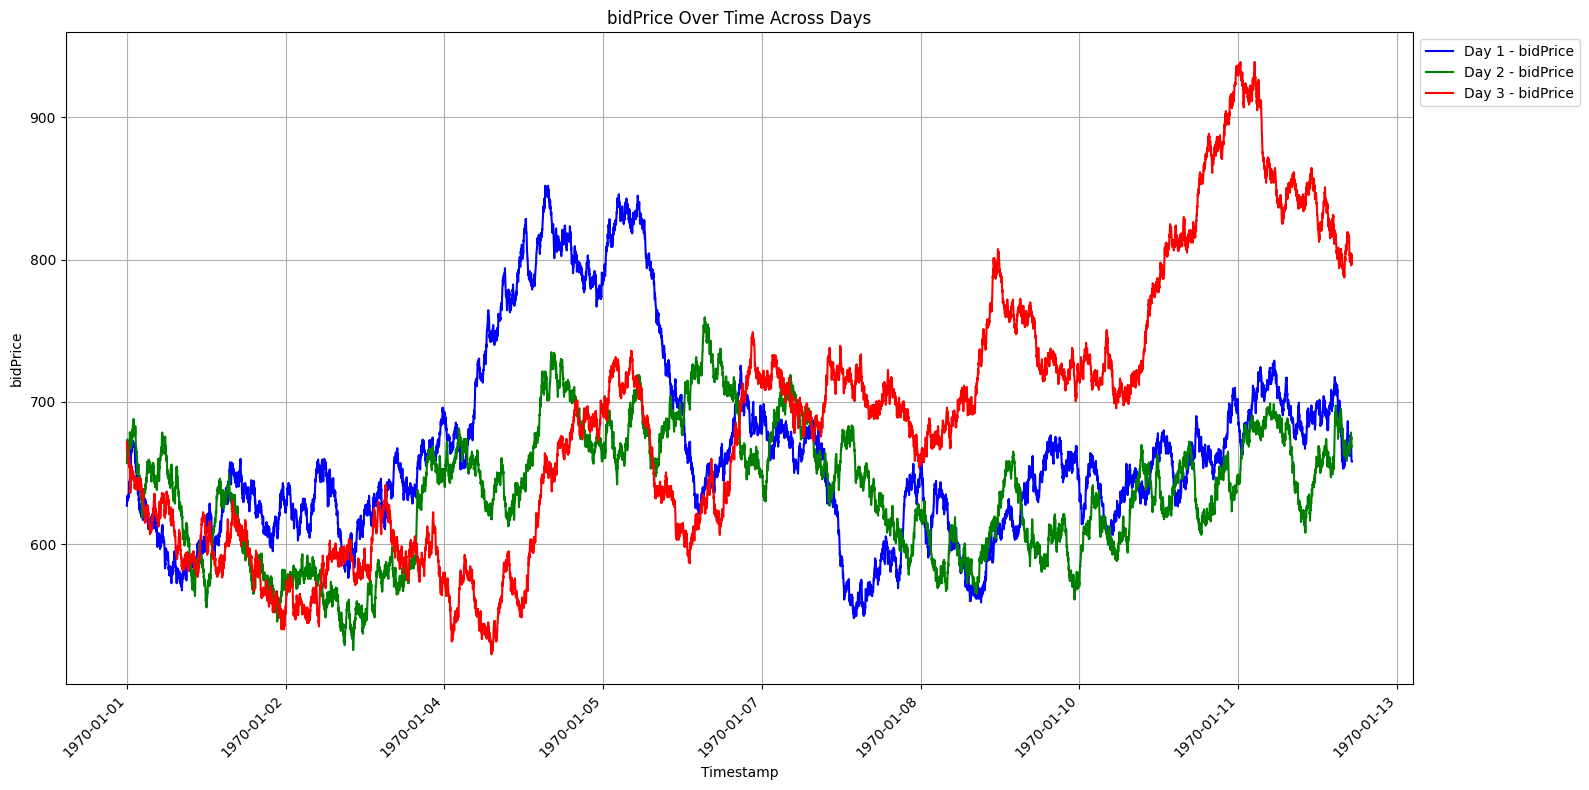

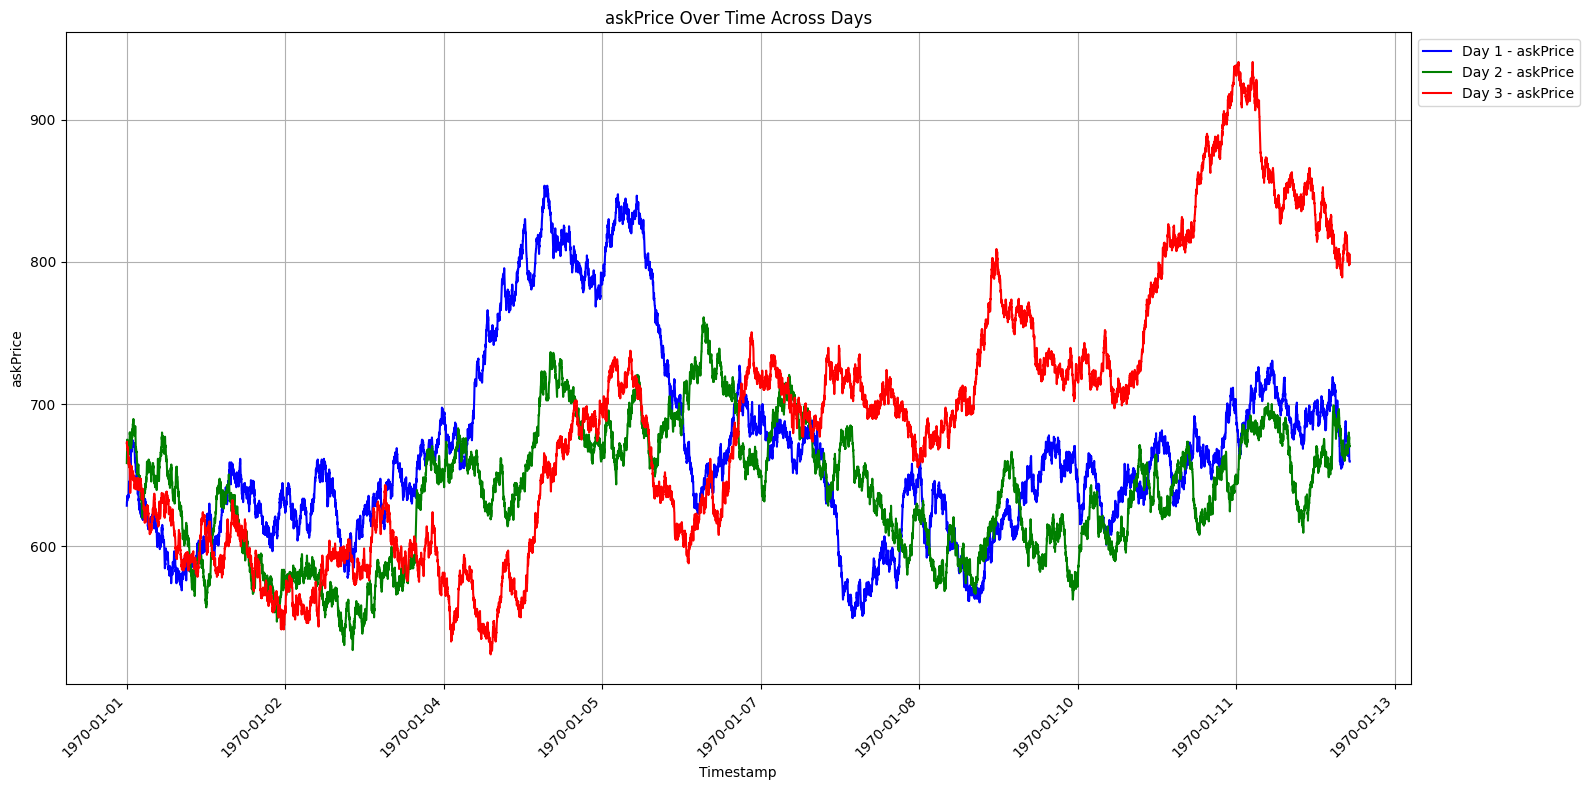

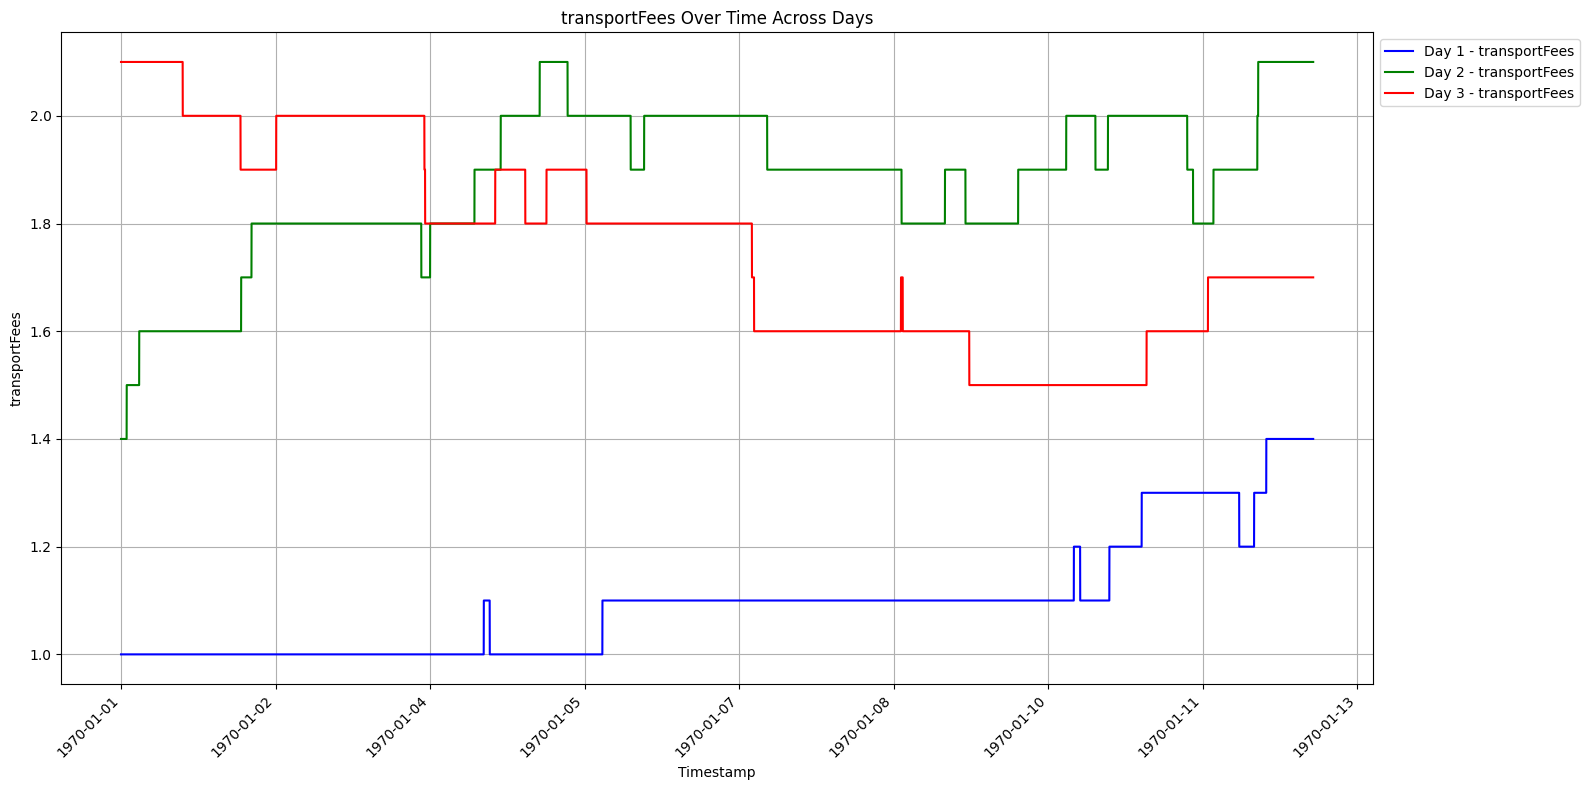

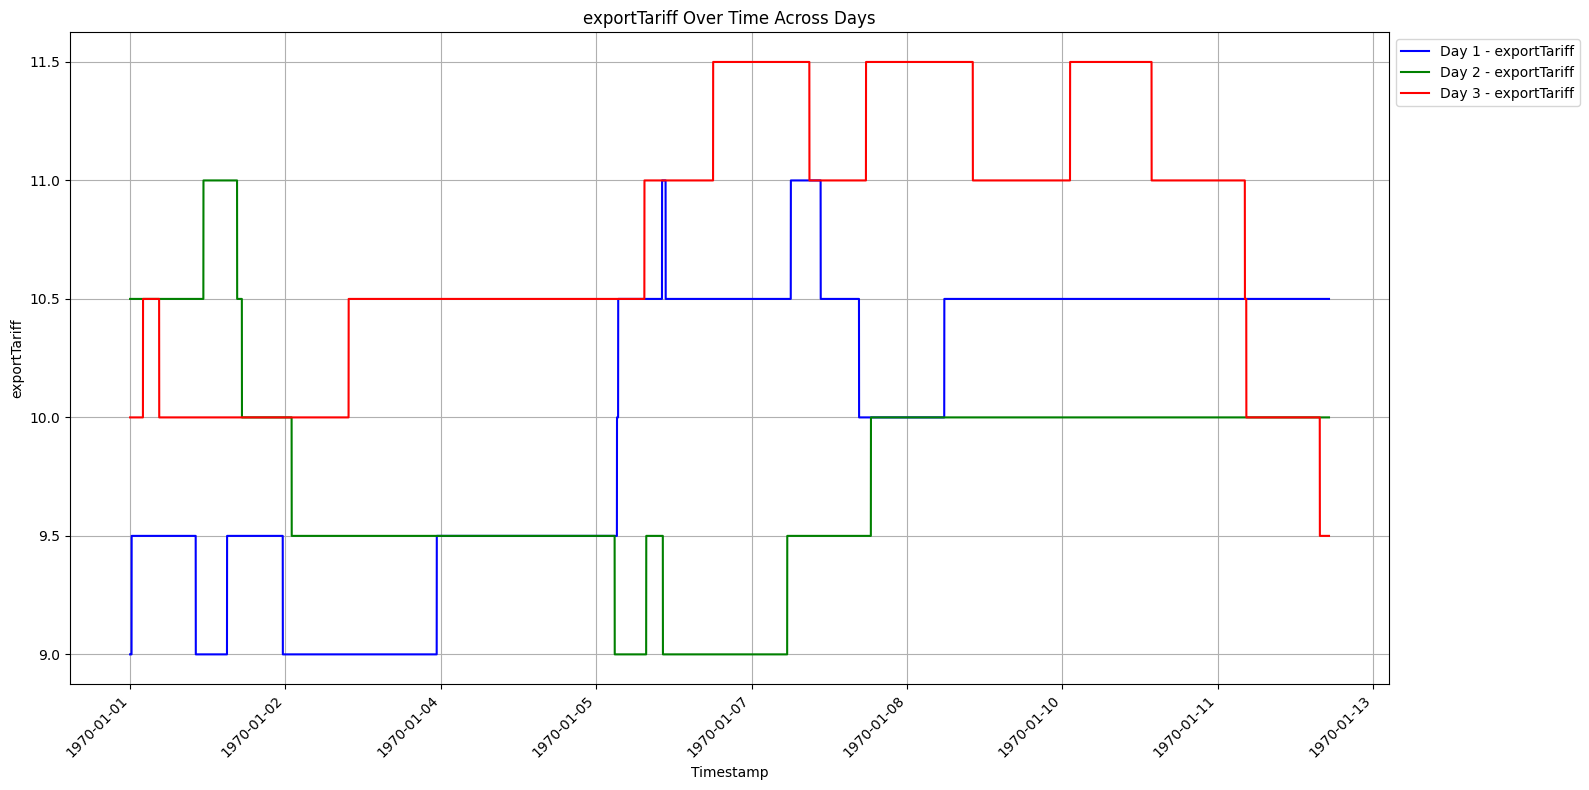

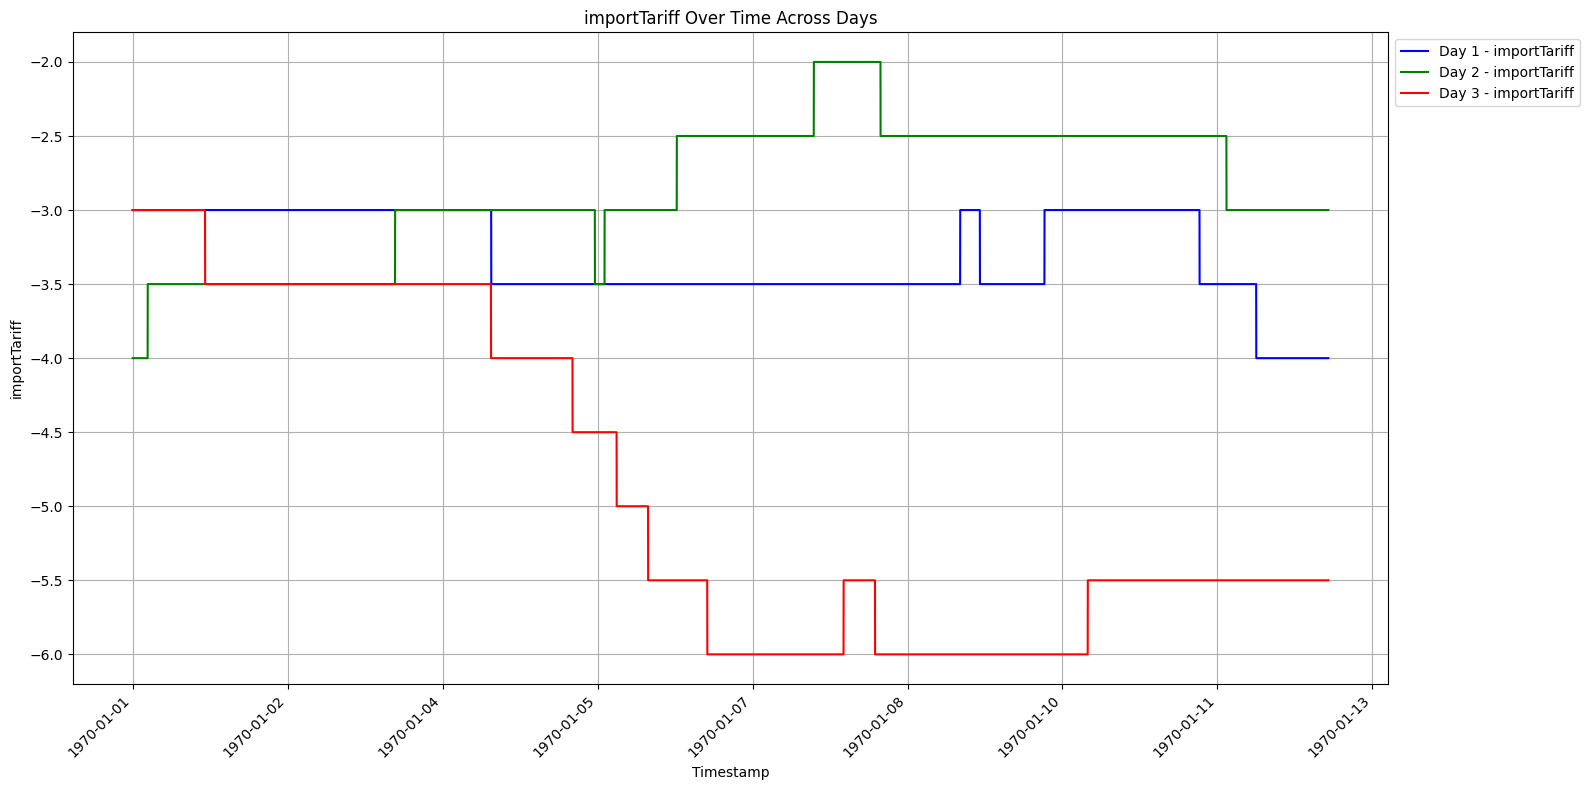

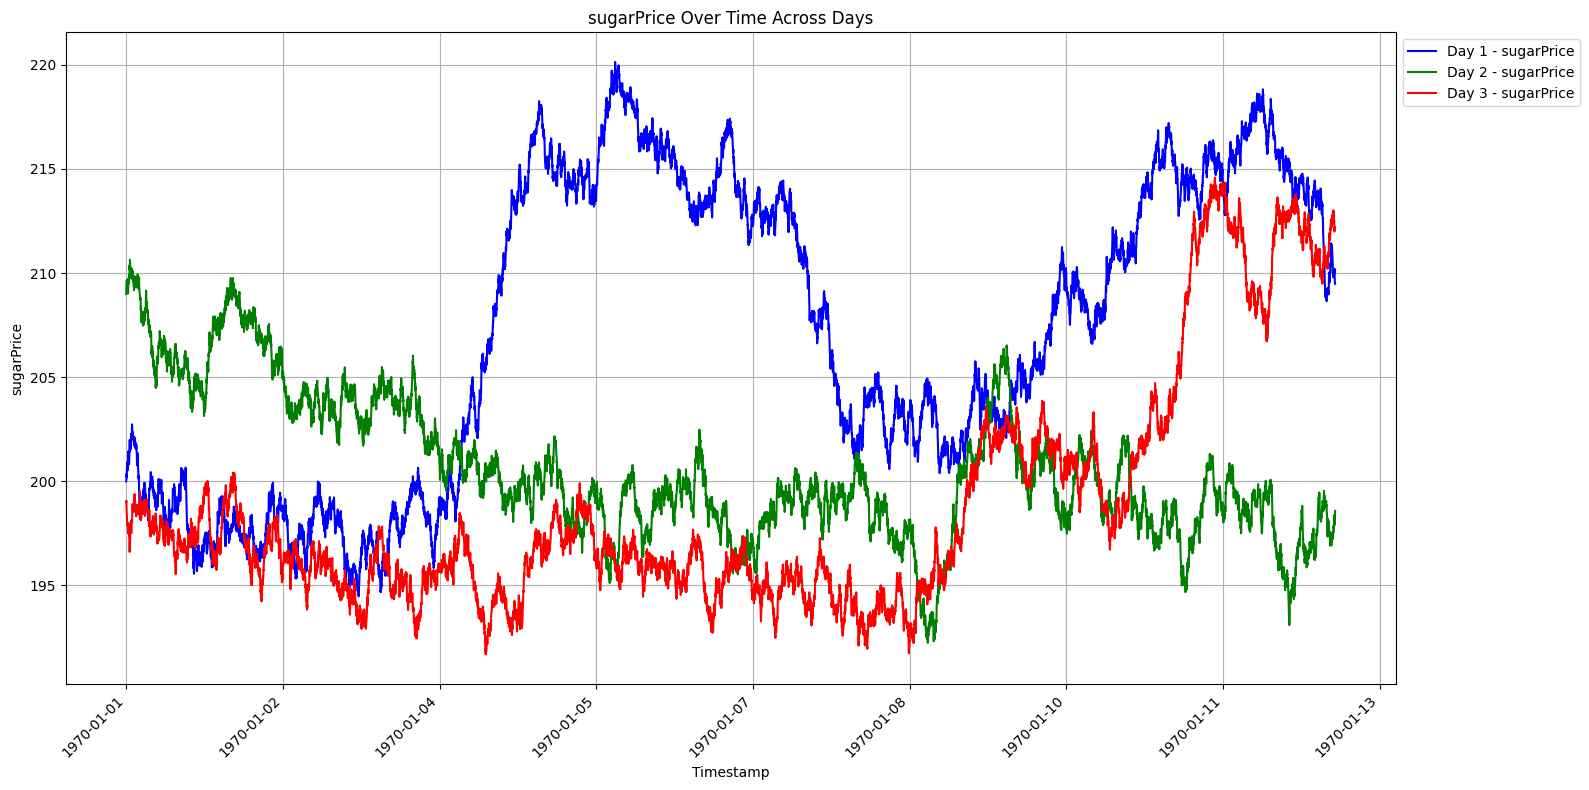

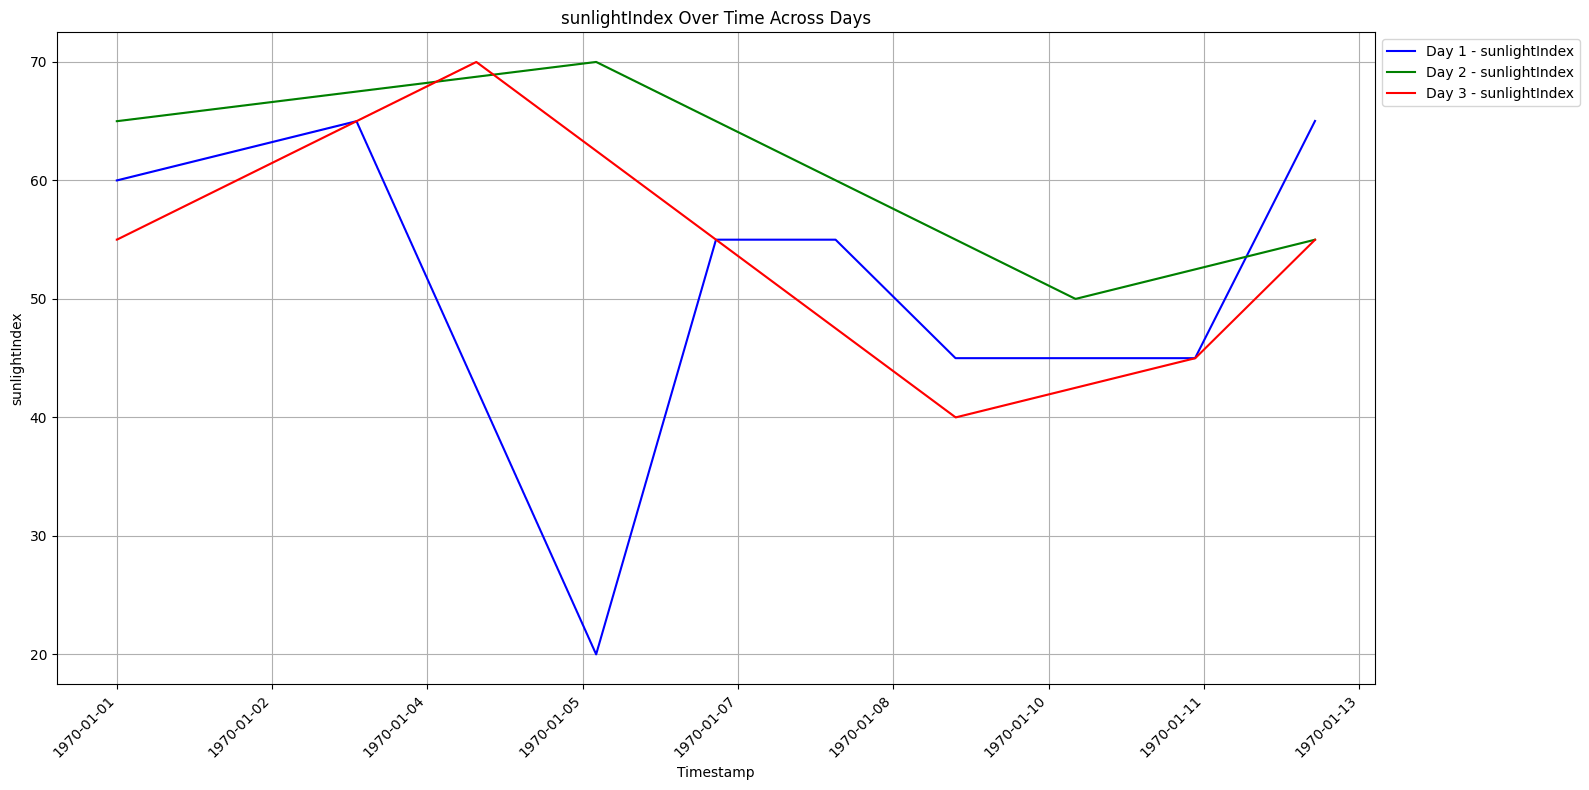

In [ ]:
obs_df = load_all_days_observations(round_, days, root)

# Visualizing multiple variables
for var in ['bidPrice', 'askPrice', 'transportFees', 'exportTariff', 'importTariff', 'sugarPrice', 'sunlightIndex']:
    plot_observation_variable_across_days(obs_df, variable=var, days=days)

In [22]:
observations_stats = analyze_observations(obs_df)

In [23]:
observations_stats.head(15)

day  bidPrice_mean  bidPrice_std  bidPrice_min  bidPrice_max  \
0    1      665.84820     66.382683         548.0         852.0   
1    2      637.27575     45.207716         525.5         759.5   
2    3      685.51640     95.102579         522.5         939.0   

   bidPrice_median  bidPrice_count  askPrice_mean  askPrice_std  askPrice_min  \
0           654.25           10000       667.3626     66.383967         549.5   
1           641.00           10000       638.7903     45.208348         527.0   
2           686.75           10000       687.0319     95.103632         524.0   

   ...  sugarPrice_min  sugarPrice_max  sugarPrice_median  sugarPrice_count  \
0  ...      194.470343      220.140330         207.762831             10000   
1  ...      192.238505      210.633490         199.800805             10000   
2  ...      191.684683      214.590231         196.764116             10000   

   sunlightIndex_mean  sunlightIndex_std  sunlightIndex_min  \
0           49.751755          10.800482               20.0   
1           61.500500           6.788701               50.0   
2           54.250000           9.324494               40.0   

   sunlightIndex_max  sunlightIndex_median  sunlightIndex_count  
0              65.02                50.265                10000  
1              70.00                65.000                10000  
2              70.00                55.000                10000  

[3 rows x 43 columns]

In [26]:
# Stats extraction:
raw_prices = load_all_days_prices(round_, days, root)
raw_trades = load_all_days_trades(round_, days, root)

pp = preprocess_prices(raw_prices)
pt = preprocess_trades(raw_trades)

price_stats = analyze_prices(pp)
trade_stats = analyze_trades(pt)

# Exporting combined stats across all days:
export_stats(price_stats, f'../../data/round-{round_}-island-data-bottle/price_stats_all_days.csv')
export_stats(trade_stats, f'../../data/round-{round_}-island-data-bottle/trade_stats_all_days.csv')

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
price_stats.head(15)

product  day     mean_mid    std_mid  min_mid  max_mid  \
0             CROISSANTS    1   4269.00945   9.078903   4251.0   4296.5   
1             CROISSANTS    2   4254.71995  10.686226   4232.0   4278.5   
2             CROISSANTS    3   4257.09385  20.876774   4226.5   4314.5   
3                DJEMBES    1  13385.98110  14.916849  13353.0  13433.5   
4                DJEMBES    2  13340.50955  60.223413  13263.5  13498.5   
5                DJEMBES    3  13319.94205  28.142092  13242.5  13379.5   
6                   JAMS    1   6524.04540   9.558477   6498.5   6552.5   
7                   JAMS    2   6506.14450  19.178575   6470.0   6554.0   
8                   JAMS    3   6499.03540  23.830363   6438.0   6540.5   
9                   KELP    1   2046.15235   9.566837   2030.5   2065.5   
10                  KELP    2   2048.75010   1.568453   2040.0   2052.5   
11                  KELP    3   2037.54560   3.848779   2029.5   2047.0   
12  MAGNIFICENT_MACARONS    1    666.60005  66.393650    549.0    854.5   
13  MAGNIFICENT_MACARONS    2    638.03595  45.216842    526.0    760.0   
14  MAGNIFICENT_MACARONS    3    686.27170  95.114646    523.5    940.5   

    median_mid  skew_mid  kurtosis_mid  mean_spread  std_spread  \
0       4268.5  0.481753     -0.078836       1.2127    0.409238   
1       4253.5  0.048166     -0.727708       1.1995    0.399644   
2       4252.5  0.354930     -1.158026       1.2003    0.400245   
3      13383.5  0.597854     -0.144486       1.2576    0.437334   
4      13309.5  0.935511     -0.238202       1.2653    0.441515   
5      13324.5 -0.074129     -0.891323       1.2611    0.439256   
6       6523.0  0.474776      0.428688       1.6148    0.486667   
7       6507.0  0.086928     -0.662821       1.6074    0.488353   
8       6504.5 -0.866121     -0.154295       1.6326    0.482121   
9       2045.0  0.140023     -1.297693       2.7259    0.883203   
10      2049.0 -1.681770      4.965886       2.7382    0.895623   
11      2037.5  0.312866     -0.691851       2.7274    0.892731   
12       655.0  0.961201      0.422513       7.7507    1.125467   
13       641.5 -0.016387     -0.692779       8.2289    1.134651   
14       687.5  0.577739     -0.331419       8.6344    1.147113   

    realized_volatility  price_entry_count  
0              0.009516              10000  
1              0.009382              10000  
2              0.009995              10000  
3              0.006428              10000  
4              0.007016              10000  
5              0.007195              10000  
6              0.008018              10000  
7              0.008194              10000  
8              0.011636              10000  
9              0.038017              10000  
10             0.037780              10000  
11             0.038630              10000  
12             0.385733              10000  
13             0.408385              10000  
14             0.388174              10000

In [28]:
trade_stats.head(15)

product  day  trade_count  total_volume  mean_trade_price  \
0             CROISSANTS    1          973          6468       4268.932169   
1             CROISSANTS    2          989          6556       4254.567240   
2             CROISSANTS    3          945          6096       4256.936508   
3                DJEMBES    1          992          3427      13385.990927   
4                DJEMBES    2         1016          3454      13340.678150   
5                DJEMBES    3         1038          3468      13320.035645   
6                   JAMS    1         1142          8165       6523.604203   
7                   JAMS    2         1165          8144       6505.589700   
8                   JAMS    3         1168          8211       6498.752568   
9                   KELP    1         2987          8302       2045.915969   
10                  KELP    2         2899          8437       2048.353570   
11                  KELP    3         2911          8191       2037.074201   
12  MAGNIFICENT_MACARONS    1          371          1769        665.121294   
13  MAGNIFICENT_MACARONS    2          347          1590        643.694524   
14  MAGNIFICENT_MACARONS    3          363          1686        682.052342   

    median_trade_price  std_trade_price  min_trade_price  max_trade_price  \
0               4269.0         9.311456           4251.0           4297.0   
1               4254.0        10.742419           4232.0           4279.0   
2               4252.0        20.945960           4227.0           4314.0   
3              13384.0        14.824943          13355.0          13431.0   
4              13310.0        61.186413          13266.0          13496.0   
5              13324.0        28.451073          13249.0          13378.0   
6               6522.5         9.974336           6498.0           6552.0   
7               6507.0        18.781660           6470.0           6553.0   
8               6504.0        24.277133           6438.0           6541.0   
9               2045.0         9.610044           2030.0           2066.0   
10              2048.0         1.951145           2039.0           2053.0   
11              2037.0         4.055880           2029.0           2048.0   
12               652.0        64.182585            546.0            846.0   
13               648.0        48.363317            539.0            755.0   
14               687.0        91.771786            535.0            936.0   

            vwap  mean_trade_size  median_trade_size  std_trade_size  \
0    4268.882189         6.647482                7.0        1.412061   
1    4254.485662         6.628918                7.0        1.445646   
2    4256.924049         6.450794                6.0        1.363089   
3   13385.918879         3.454637                3.0        2.018071   
4   13338.418066         3.399606                3.0        1.900417   
5   13320.004325         3.341040                3.0        1.939110   
6    6523.637110         7.149737                7.0        2.316612   
7    6505.491405         6.990558                7.0        2.314770   
8    6498.373767         7.029966                7.0        2.313100   
9    2045.923994         2.779377                1.0        3.223096   
10   2048.605903         2.910314                1.0        3.416493   
11   2037.202906         2.813810                1.0        3.277597   
12    665.730356         4.768194                5.0        1.463118   
13    644.307547         4.582133                5.0        1.509516   
14    683.758600         4.644628                5.0        1.385757   

    max_trade_size  mean_inter_arrival_s  std_inter_arrival_s  
0               10           1026.413155          1003.487326  
1               10           1009.908999           929.434818  
2               10           1057.883598          1020.449680  
3               11           1006.350806           974.958919  
4               11            981.496063           963.998307 

# Round 5

### Generating insights

In [37]:
round_ = 5

# Specifying your days and root folder:
days = [2, 3, 4]
root = f'../../data/round-{round_}-island-data-bottle/'

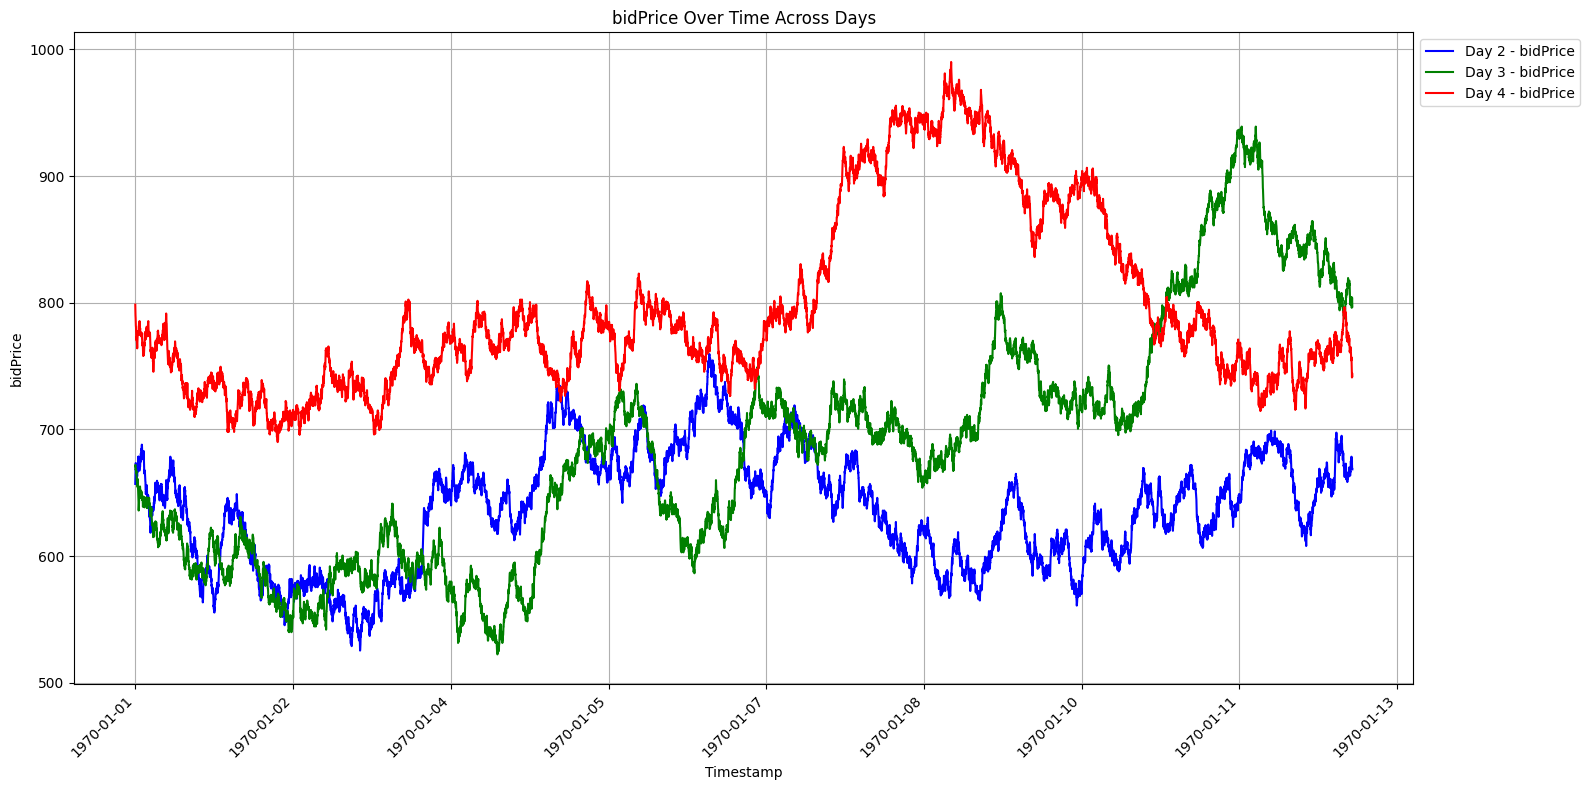

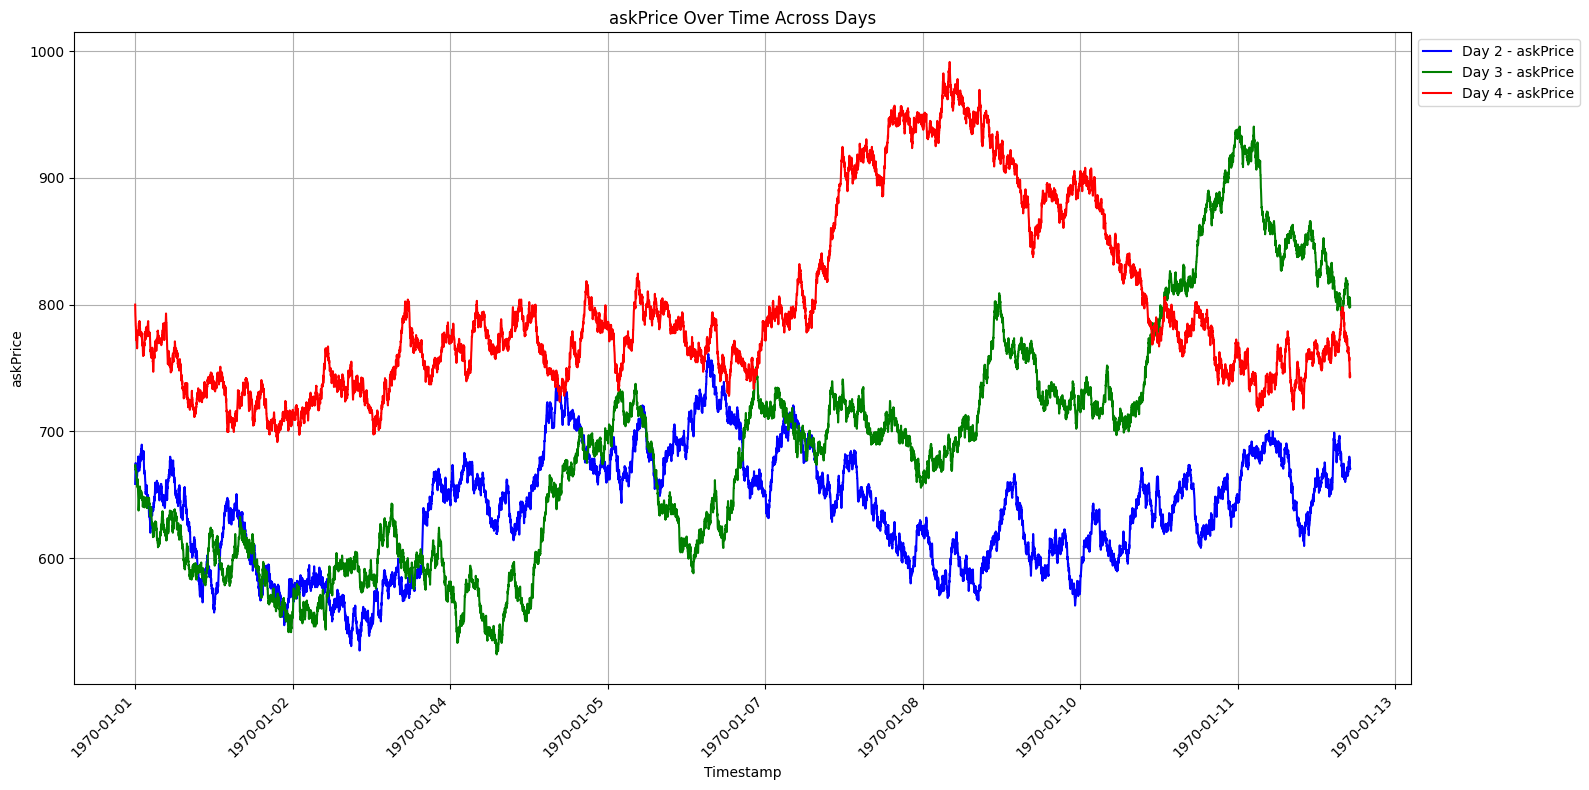

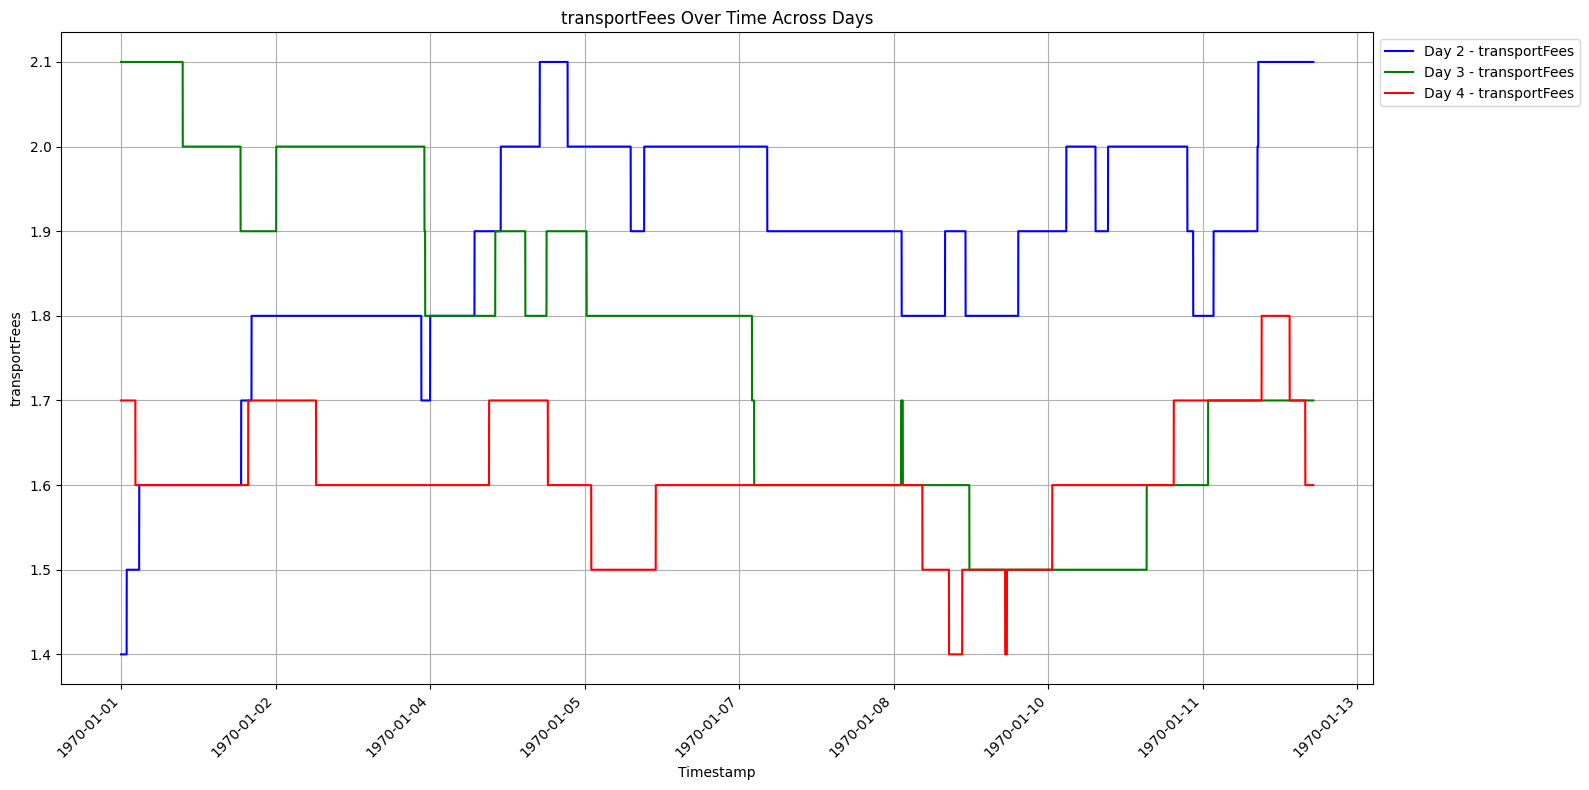

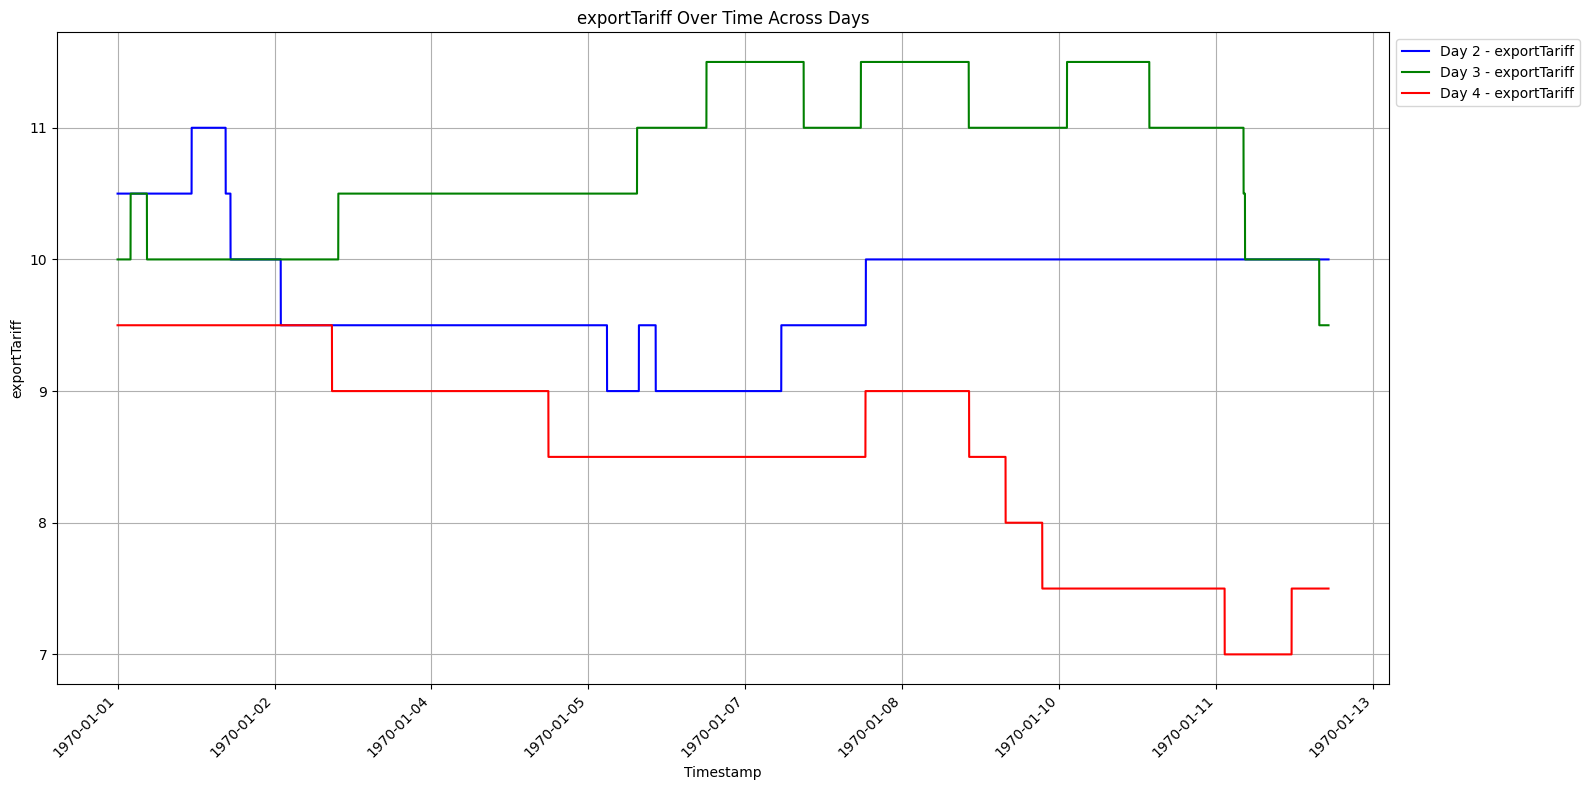

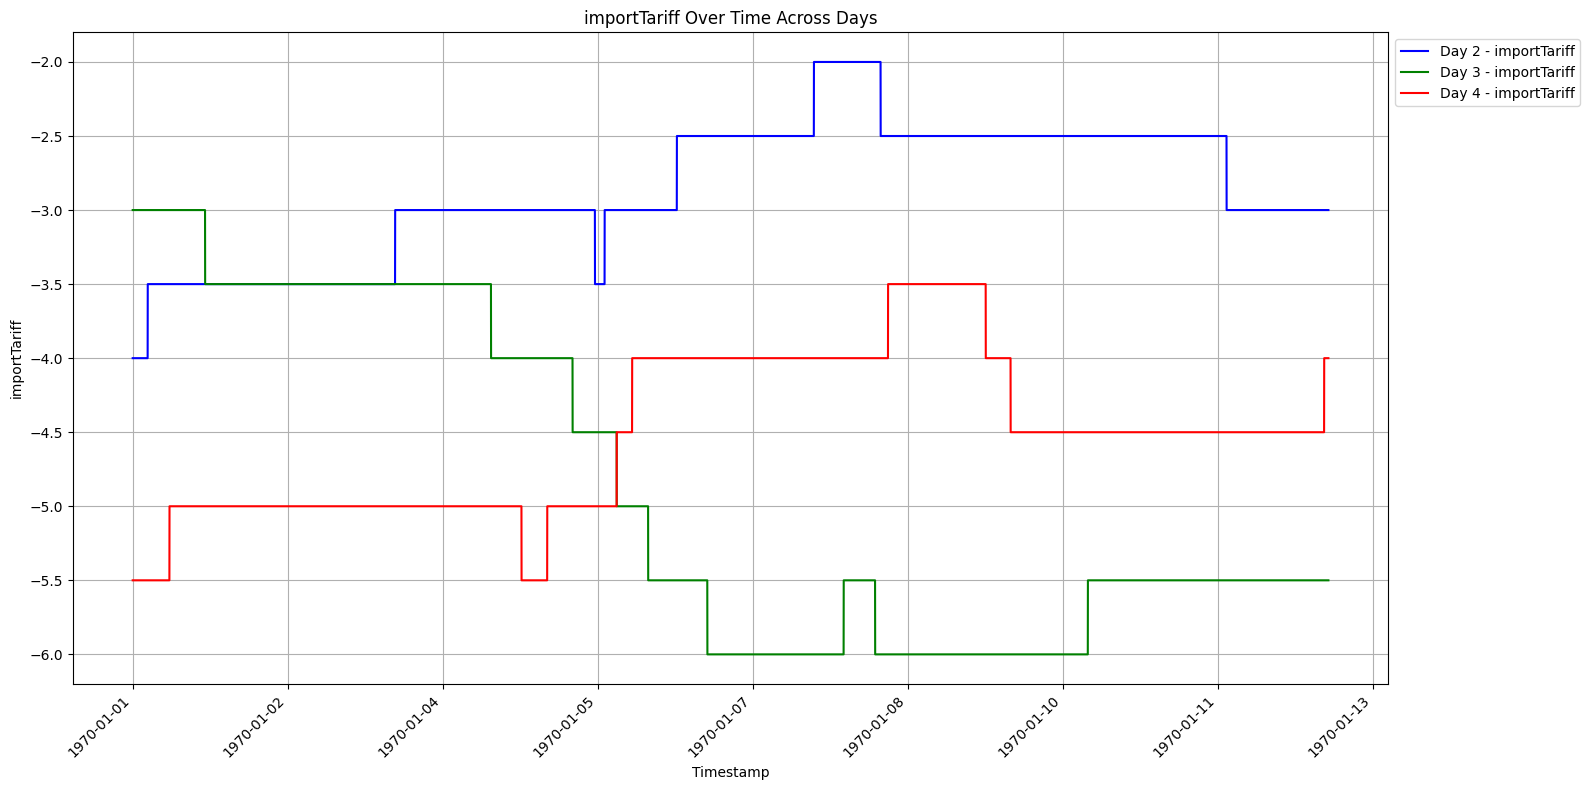

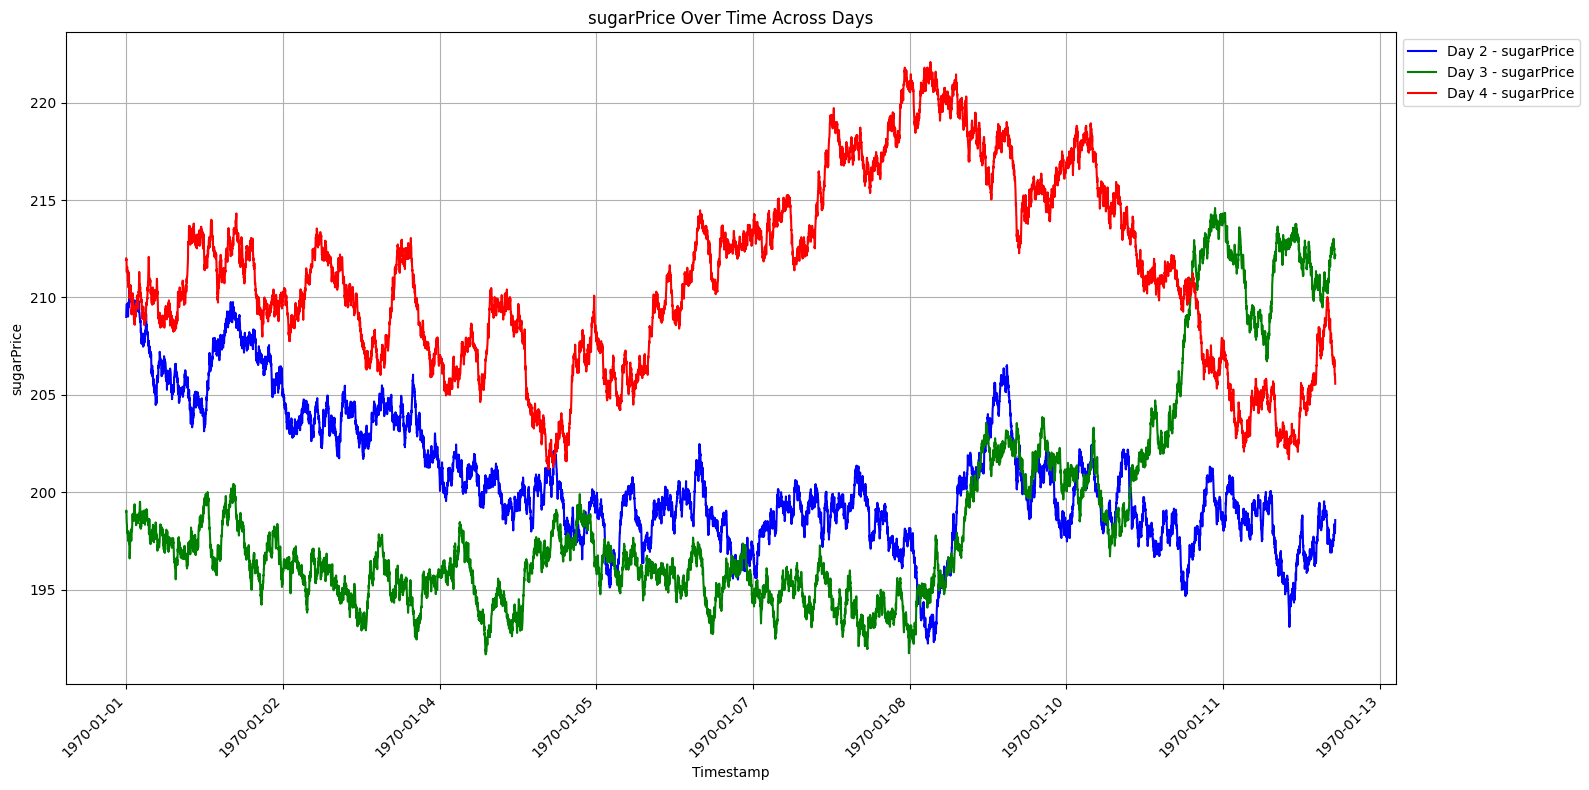

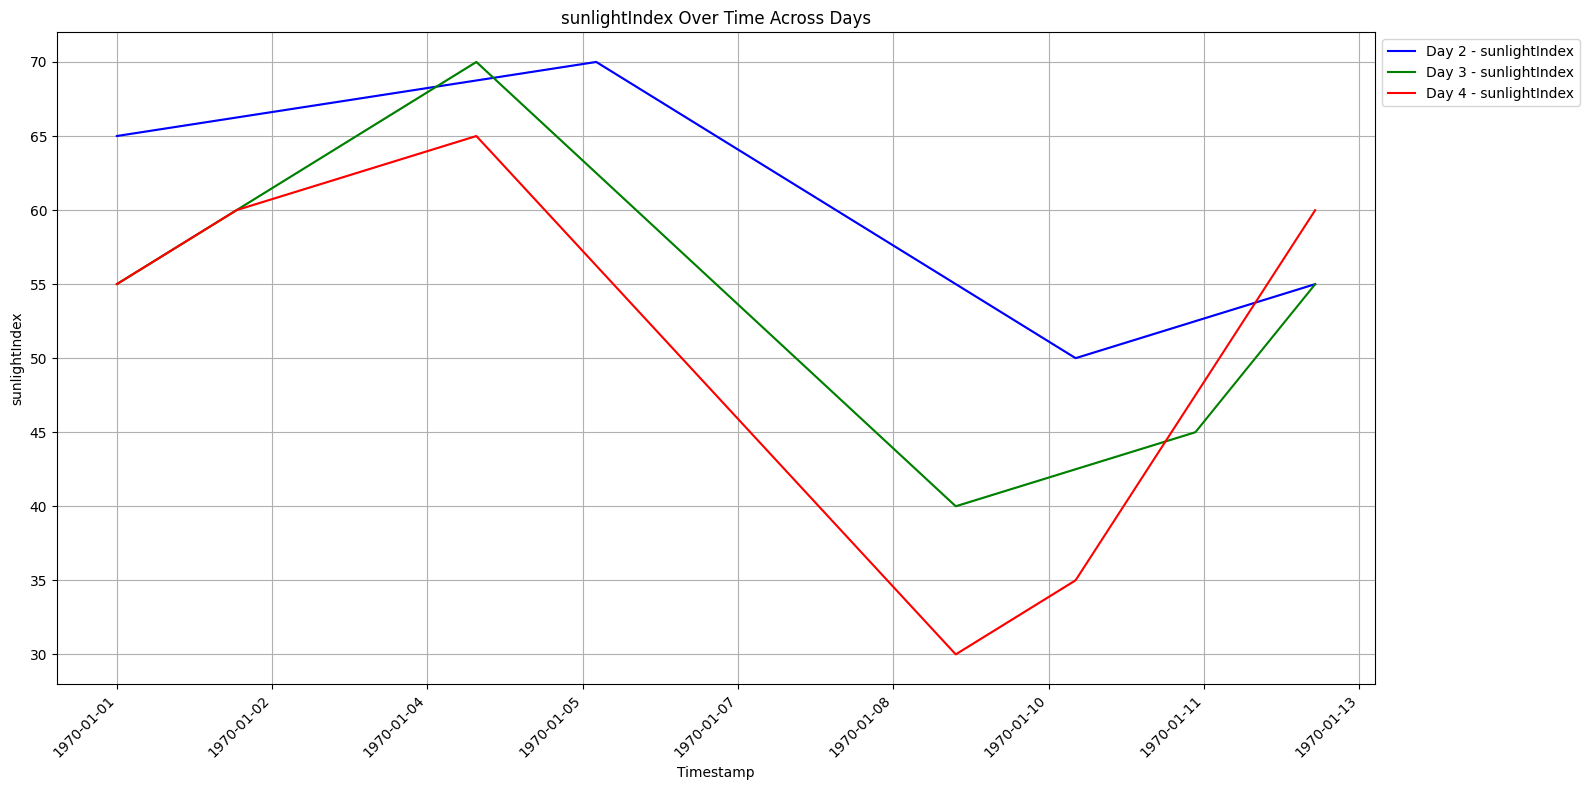

In [38]:
obs_df = load_all_days_observations(round_, days, root)

# Visualizing multiple variables
for var in ['bidPrice', 'askPrice', 'transportFees', 'exportTariff', 'importTariff', 'sugarPrice', 'sunlightIndex']:
    plot_observation_variable_across_days(obs_df, variable=var, days=days)

In [39]:
observations_stats = analyze_observations(obs_df)

In [40]:
observations_stats.head(15)

day  bidPrice_mean  bidPrice_std  bidPrice_min  bidPrice_max  \
0    2      637.27575     45.207716         525.5         759.5   
1    3      685.51640     95.102579         522.5         939.0   
2    4      796.20050     70.656466         690.0         990.0   

   bidPrice_median  bidPrice_count  askPrice_mean  askPrice_std  askPrice_min  \
0           641.00           10000      638.79030     45.208348         527.0   
1           686.75           10000      687.03190     95.103632         524.0   
2           773.50           10000      797.71585     70.656308         691.5   

   ...  sugarPrice_min  sugarPrice_max  sugarPrice_median  sugarPrice_count  \
0  ...      192.238505      210.633490         199.800805             10000   
1  ...      191.684683      214.590231         196.764116             10000   
2  ...      201.190599      222.084542         210.861769             10000   

   sunlightIndex_mean  sunlightIndex_std  sunlightIndex_min  \
0           61.500500           6.788701               50.0   
1           54.250000           9.324494               40.0   
2           49.999746          11.105936               30.0   

   sunlightIndex_max  sunlightIndex_median  sunlightIndex_count  
0               70.0                65.000                10000  
1               70.0                55.000                10000  
2               65.0                52.645                10000  

[3 rows x 43 columns]

In [41]:
# Stats extraction:
raw_prices = load_all_days_prices(round_, days, root)
raw_trades = load_all_days_trades(round_, days, root)

pp = preprocess_prices(raw_prices)
pt = preprocess_trades(raw_trades)

price_stats = analyze_prices(pp)
trade_stats = analyze_trades(pt)

# Exporting combined stats across all days:
export_stats(price_stats, f'../../data/round-{round_}-island-data-bottle/price_stats_all_days.csv')
export_stats(trade_stats, f'../../data/round-{round_}-island-data-bottle/trade_stats_all_days.csv')

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [42]:
price_stats.head(15)

product  day     mean_mid    std_mid  min_mid  max_mid  \
0             CROISSANTS    2   4254.71995  10.686226   4232.0   4278.5   
1             CROISSANTS    3   4257.09385  20.876774   4226.5   4314.5   
2             CROISSANTS    4   4285.31755   8.706246   4263.5   4307.5   
3                DJEMBES    2  13340.50955  60.223413  13263.5  13498.5   
4                DJEMBES    3  13319.94205  28.142092  13242.5  13379.5   
5                DJEMBES    4  13366.07065  23.171730  13317.0  13419.5   
6                   JAMS    2   6506.14450  19.178575   6470.0   6554.0   
7                   JAMS    3   6499.03540  23.830363   6438.0   6540.5   
8                   JAMS    4   6453.30470  19.942557   6411.5   6521.0   
9                   KELP    2   2048.75010   1.568453   2040.0   2052.5   
10                  KELP    3   2037.54560   3.848779   2029.5   2047.0   
11                  KELP    4   2019.84490   9.295719   2006.5   2039.5   
12  MAGNIFICENT_MACARONS    2    638.03595  45.216842    526.0    760.0   
13  MAGNIFICENT_MACARONS    3    686.27170  95.114646    523.5    940.5   
14  MAGNIFICENT_MACARONS    4    796.95815  70.663902    691.0    991.0   

    median_mid  skew_mid  kurtosis_mid  mean_spread  std_spread  \
0       4253.5  0.048166     -0.727708       1.1995    0.399644   
1       4252.5  0.354930     -1.158026       1.2003    0.400245   
2       4284.5  0.207256     -0.482131       1.2093    0.406829   
3      13309.5  0.935511     -0.238202       1.2653    0.441515   
4      13324.5 -0.074129     -0.891323       1.2611    0.439256   
5      13365.5  0.044452     -1.144380       1.2673    0.442572   
6       6507.0  0.086928     -0.662821       1.6074    0.488353   
7       6504.5 -0.866121     -0.154295       1.6326    0.482121   
8       6450.0  0.595281     -0.210521       1.6150    0.486620   
9       2049.0 -1.681770      4.965886       2.7382    0.895623   
10      2037.5  0.312866     -0.691851       2.7274    0.892731   
11      2014.5  0.667695     -1.105076       2.7178    0.896462   
12       641.5 -0.016387     -0.692779       8.2289    1.134651   
13       687.5  0.577739     -0.331419       8.6344    1.147113   
14       774.5  0.970640     -0.209642       7.4073    1.050199   

    realized_volatility  price_entry_count  
0              0.009382              10000  
1              0.009995              10000  
2              0.009637              10000  
3              0.007016              10000  
4              0.007195              10000  
5              0.005986              10000  
6              0.008194              10000  
7              0.011636              10000  
8              0.013417              10000  
9              0.037780              10000  
10             0.038630              10000  
11             0.038876              10000  
12             0.408385              10000  
13             0.388174              10000  
14             0.323316              10000

In [43]:
trade_stats.head(15)    

product  day  trade_count  total_volume  mean_trade_price  \
0             CROISSANTS    2          989          6556       4254.567240   
1             CROISSANTS    3          945          6096       4256.936508   
2             CROISSANTS    4         1016          6707       4285.400591   
3                DJEMBES    2         1016          3454      13340.678150   
4                DJEMBES    3         1038          3468      13320.035645   
5                DJEMBES    4         1057          3712      13365.583728   
6                   JAMS    2         1165          8144       6505.589700   
7                   JAMS    3         1168          8211       6498.752568   
8                   JAMS    4         1201          8630       6453.166528   
9                   KELP    2         2899          8437       2048.353570   
10                  KELP    3         2911          8191       2037.074201   
11                  KELP    4         2898          8375       2019.897861   
12  MAGNIFICENT_MACARONS    2          347          1590        643.694524   
13  MAGNIFICENT_MACARONS    3          363          1686        682.052342   
14  MAGNIFICENT_MACARONS    4          367          1712        796.833787   

    median_trade_price  std_trade_price  min_trade_price  max_trade_price  \
0               4254.0        10.742419           4232.0           4279.0   
1               4252.0        20.945960           4227.0           4314.0   
2               4284.0         8.884811           4263.0           4307.0   
3              13310.0        61.186413          13266.0          13496.0   
4              13324.0        28.451073          13249.0          13378.0   
5              13364.0        23.468322          13318.0          13418.0   
6               6507.0        18.781660           6470.0           6553.0   
7               6504.0        24.277133           6438.0           6541.0   
8               6451.0        19.959223           6411.0           6522.0   
9               2048.0         1.951145           2039.0           2053.0   
10              2037.0         4.055880           2029.0           2048.0   
11              2015.0         9.541143           2006.0           2040.0   
12               648.0        48.363317            539.0            755.0   
13               687.0        91.771786            535.0            936.0   
14               782.0        68.191927            695.0            963.0   

            vwap  mean_trade_size  median_trade_size  std_trade_size  \
0    4254.485662         6.628918                7.0        1.445646   
1    4256.924049         6.450794                6.0        1.363089   
2    4285.325332         6.601378                6.0        1.397943   
3   13338.418066         3.399606                3.0        1.900417   
4   13320.004325         3.341040                3.0        1.939110   
5   13365.754849         3.511826                3.0        2.056978   
6    6505.491405         6.990558                7.0        2.314770   
7    6498.373767         7.029966                7.0        2.313100   
8    6453.300000         7.185679                7.0        2.305716   
9    2048.605903         2.910314                1.0        3.416493   
10   2037.202906         2.813810                1.0        3.277597   
11   2020.079522         2.889924                1.0        3.392101   
12    644.307547         4.582133                5.0        1.509516   
13    683.758600         4.644628                5.0        1.385757   
14    798.110397         4.664850                5.0        1.425544   

    max_trade_size  mean_inter_arrival_s  std_inter_arrival_s  
0               10           1009.908999           929.434818  
1               10           1057.883598          1020.449680  
2               10            983.366142           894.993677  
3               11            981.496063           963.998307  
4               11            962.331407           920.356498 